This R Jupyter notebook describes code for processing and visualizing 16S and 12S rRNA amplicon data for the following manuscript:
<br> 
*Optimizing in-cartridge bead beating extraction of microbial and fish environmental DNA* (in review)
<br> 
Sean R. Anderson and Luke R. Thompson
<br> 
June 2021

Load R packages needed for this workflow. All input files are availabile on the Sterivex GitHub repo, separated in folders for specific gene marker regions (16S, 16S-plastid, 12S).  

In [2]:
library(qiime2R)
library(phyloseq)
library(tidyverse)
library(vegan)
library(fantaxtic)
library(RColorBrewer)
library(ranacapa)
library(MicEco)
library(ggpubr)

Load taxonomy and count files (.qza) from QIIME 2 and Tourmaline using the qiime2R package. We will start with the 16S rRNA dataset. 

In [4]:
ASVs_16S <- read_qza(file="/16S/table.qza")
ASVs_16S <- ASVs_16S$data %>% as.data.frame()
tax_16S <- read_qza(file="/16S/taxonomy.qza")
tax_16S <- tax_16S$data %>% 
    as.data.frame() %>%
    separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>%
    column_to_rownames("Feature.ID") 
    tax_16S$Confidence <- NULL

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 5292 rows [1, 2, 4, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 21, 22, 25, 27, 28, 29, 30, ...].”


Clean up taxonomy table; remove unassigned reads at the kingdom level and relabel taxa to remove unnecessary text (e.g., p__Proteobacteria becomes Proteobacteria).

In [5]:
tax_16S <- subset(tax_16S,!grepl("Unassigned",tax_16S$Kingdom))
tax_16S$Kingdom <- gsub("^.{0,3}", "", tax_16S$Kingdom)
tax_16S$Phylum <- gsub("^.{0,4}", "", tax_16S$Phylum)
tax_16S$Class <- gsub("^.{0,4}", "", tax_16S$Class)
tax_16S$Order <- gsub("^.{0,4}", "", tax_16S$Order)
tax_16S$Family <- gsub("^.{0,4}", "", tax_16S$Family)
tax_16S$Genus <- gsub("^.{0,4}", "", tax_16S$Genus)
tax_16S$Species <- gsub("^.{0,4}", "", tax_16S$Species)
tax_16S[tax_16S=="uncultured" | tax_16S == "uncultured_bacterium"]<-NA

Load rooted phylogenetic tree file for 16S.

In [6]:
tree_16S<- read_qza(file="/16S/rooted_tree.qza")

Load metadata file for 16S samples.

In [7]:
sample_info_tab<- read_tsv(file="/16S/metadata.tsv")
sample_info_tab  <- sample_data(sample_info_tab)
rownames(sample_info_tab) <- sample_info_tab$sample_name

Parsed with column specification:
cols(
  sample_name = col_character(),
  Day = col_character(),
  Extraction = col_character(),
  Temp = col_double(),
  Salinity = col_double(),
  DNA_conc = col_double(),
  Replicate = col_character()
)



Merge into a phyloseq object.

In [8]:
physeq_16S <- phyloseq(otu_table(ASVs_16S, taxa_are_rows= T), tax_table(as.matrix(tax_16S)), phy_tree(tree_16S$data), sample_data(sample_info_tab))

Perform filtering of the phyloseq object. Remove chloroplast and mitochondria reads. Chloroplast reads will be processed separately following taxonomic annotation with PhytoRef. 

In [9]:
psnew_16S = subset_taxa(physeq_16S, Order != "Chloroplast" | is.na(Order))
psnew_16S = subset_taxa(psnew_16S, Family != "Mitochondria" | is.na(Family))

# Remove controls for now.
psnew_16S = subset_samples(psnew_16S, Day != "Control")
psnew_16S = subset_samples(psnew_16S, Extraction != "MilliQ")

Plot rarefaction curves for 16S samples. 

rarefying sample B_16S_A
rarefying sample B_16S_B
rarefying sample B_16S_C
rarefying sample BY_16S_A
rarefying sample BY_16S_B
rarefying sample BY_16S_C
rarefying sample NB_16S_A
rarefying sample NB_16S_B
rarefying sample NB_16S_C
rarefying sample NM_16S_A
rarefying sample NM_16S_B
rarefying sample NM_16S_C
rarefying sample Y_16S_A
rarefying sample Y_16S_B
rarefying sample Y_16S_C
rarefying sample Zymo_NB_16S_A
rarefying sample Zymo_NB_16S_B
rarefying sample Zymo_NB_16S_C
rarefying sample Zymo1_16S_A
rarefying sample Zymo1_16S_B
rarefying sample Zymo1_16S_C
rarefying sample Zymo2_16S_A
rarefying sample Zymo2_16S_B
rarefying sample Zymo2_16S_C


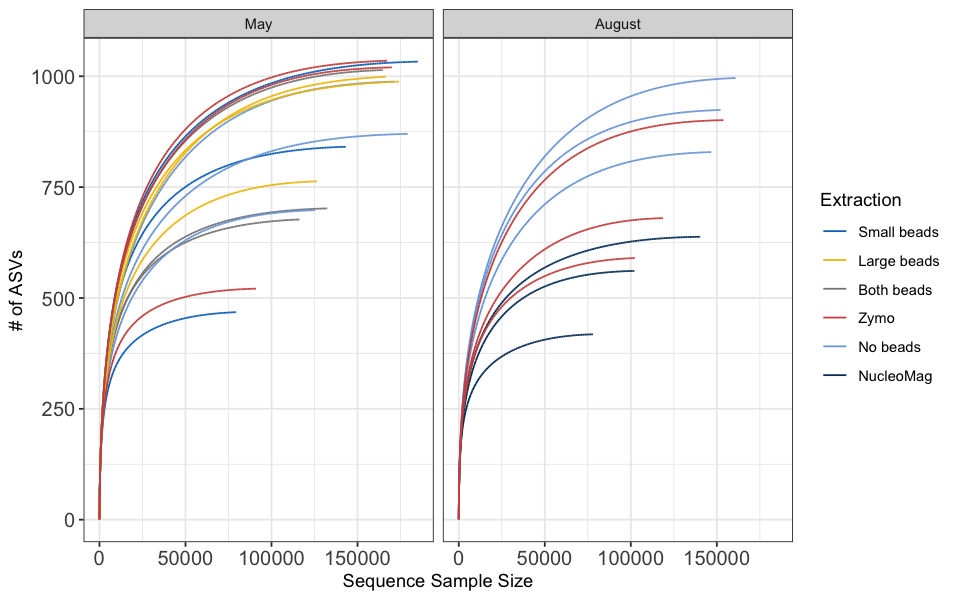

In [14]:
rare_16S <- ggrare(psnew_16S, step = 10, plot = FALSE, parallel = FALSE, se = FALSE, color = "Extraction")
rare_16S$data$Extraction <- factor(rare_16S$data$Extraction, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads", "NucleoMag"))
rare_16S + theme(legend.position = "none") + theme_bw()+ facet_grid(~factor(Day, levels = c("May", "August")), scales="free_y") +
labs(y="# of ASVs")+ theme(axis.text.x=element_text(size=12))+ theme(axis.text.y=element_text(size=12))+
scale_color_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF"))

# Sets the within-notebook plotting dimensions for all subsequent plots.
plot_image = options(repr.plot.width=8, repr.plot.height=5)

#ggsave(filename="16S_rarefaction.pdf", plot= last_plot(), device = "pdf", path = NULL, scale = 1, width = 8, height = 4, dpi = 300)

Estimate the mean, max and min number of 16S sequence read counts across all samples. 

In [15]:
bact_min <- min(sample_sums(psnew_16S))
bact_mean <- mean(sample_sums(psnew_16S))
bact_max <- max(sample_sums(psnew_16S))

Rarefy 16S samples to an even sampling depth (minimum read count).

In [10]:
suppressMessages(ps_rarefy_16S <- rarefy_even_depth(psnew_16S, sample.size = min(sample_sums(psnew_16S)), rngseed = 714, replace = TRUE, trimOTUs = TRUE, verbose = TRUE))

Estimate observed ASV richness and Shannon diversity and combine in new data frame with specific metadata factors from the phyloseq object (extraction type, DNA concentration, and sampling day). 

In [17]:
extraction_type = sample_data(ps_rarefy_16S)$Extraction
extraction_conc = sample_data(ps_rarefy_16S)$DNA_conc
extraction_day = sample_data(ps_rarefy_16S)$Day
alpha_16S <- estimate_richness(ps_rarefy_16S, measures=c("Shannon", "Observed")) %>%
cbind(extraction_type, extraction_conc, extraction_day)

Plot DNA concentration across bead treatments for 16S and facet by sampling day.

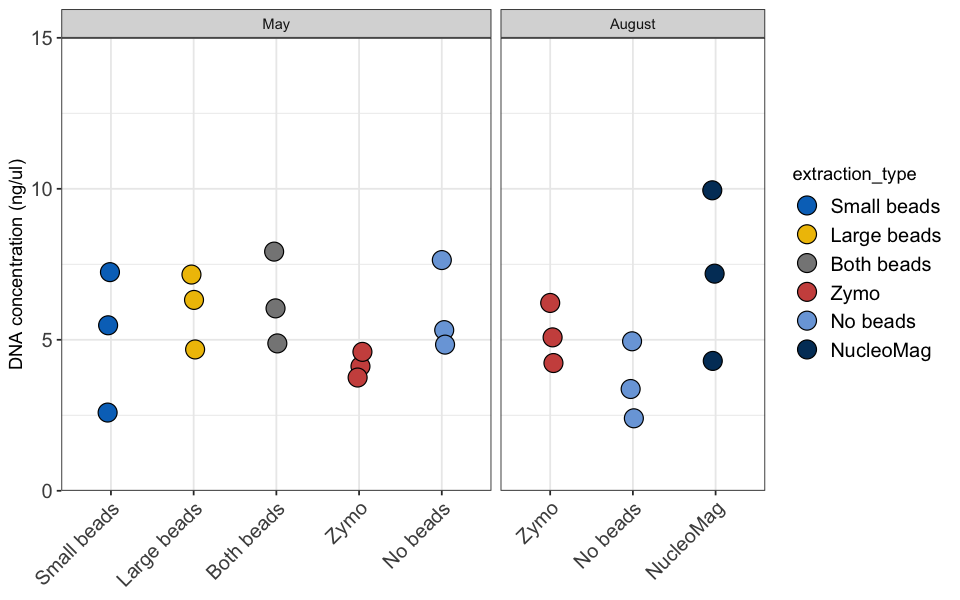

In [18]:
alpha_16S$extraction_type <- factor(alpha_16S$extraction_type, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads", "NucleoMag"))
alpha_16S$extraction_day <- factor(alpha_16S$extraction_day, levels = c("May", "August"))
DNA_16S <- ggplot(alpha_16S, aes(x=extraction_type, y = extraction_conc, fill = extraction_type))
DNA_16S + geom_point(aes(fill = extraction_type),size = 5, shape = 21, colour = "black", position = position_jitterdodge(dodge.width=0.25)) + 
   labs(y="DNA concentration (ng/ul)") + 
   scale_fill_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF")) +theme_bw() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size=12)) + 
   theme(axis.text.y = element_text(size=12))+ theme(legend.text = element_text(colour="black", size=12))+
   theme(axis.title.x = element_blank())+scale_y_continuous(expand = c(0, 0), breaks=seq(0,15,5), limits=c(0, 15))  + facet_grid(~factor(extraction_day, levels = c("May", "August")), scale = "free", space = "free")

#ggsave(filename="DNA_concentration.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 4, dpi = 600)

Test normality of the DNA concentration data. 

In [19]:
shapiro.test(alpha_16S$extraction_conc)


	Shapiro-Wilk normality test

data:  alpha_16S$extraction_conc
W = 0.96861, p-value = 0.6329


ANOVA test with Tukey post-hoc for significant differences (p < 0.05) in DNA concentration between extraction types for May or August samples. 

In [20]:
alpha_16S_may <- subset(alpha_16S, !grepl("August",alpha_16S$extraction_day))
may.aov <- aov(extraction_conc ~ extraction_type, data = alpha_16S_may)
TukeyHSD(may.aov)

alpha_16S_aug <- subset(alpha_16S, !grepl("May",alpha_16S$extraction_day))
aug.aov <- aov(extraction_conc ~ extraction_type, data = alpha_16S_aug)
TukeyHSD(aug.aov)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = extraction_conc ~ extraction_type, data = alpha_16S_may)

$extraction_type
                              diff       lwr      upr     p adj
Large beads-Small beads  0.9500000 -3.192117 5.092117 0.9378979
Both beads-Small beads   1.1766667 -2.965451 5.318784 0.8769790
Zymo-Small beads        -0.9466667 -5.088784 3.195451 0.9386223
No beads-Small beads     0.8300000 -3.312117 4.972117 0.9608170
Both beads-Large beads   0.2266667 -3.915451 4.368784 0.9997200
Zymo-Large beads        -1.8966667 -6.038784 2.245451 0.5806510
No beads-Large beads    -0.1200000 -4.262117 4.022117 0.9999777
Zymo-Both beads         -2.1233333 -6.265451 2.018784 0.4818608
No beads-Both beads     -0.3466667 -4.488784 3.795451 0.9985102
No beads-Zymo            1.7766667 -2.365451 5.918784 0.6345423


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = extraction_conc ~ extraction_type, data = alpha_16S_aug)

$extraction_type
                        diff       lwr      upr     p adj
No beads-Zymo      -1.603333 -6.320389 3.113722 0.5795939
NucleoMag-Zymo      1.970000 -2.747055 6.687055 0.4544116
NucleoMag-No beads  3.573333 -1.143722 8.290389 0.1277274


Plot 16S species richness (# of ASVs) per extraction type and facet by day. 

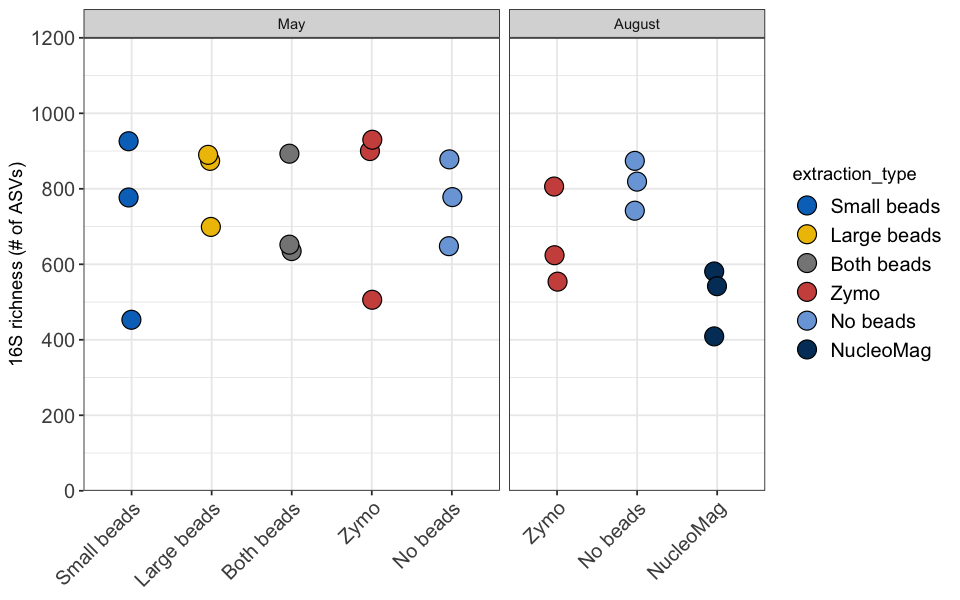

In [21]:
alpha_16S$extraction_type <- factor(alpha_16S$extraction_type, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads", "NucleoMag"))
Rich_16S <- ggplot(alpha_16S, aes(x=extraction_type, y = Observed, fill = extraction_type))
Rich_16S + geom_point(aes(fill = extraction_type),size = 5, shape = 21, colour = "black", position = position_jitterdodge(dodge.width=0.25)) +
   labs(y="16S richness (# of ASVs)") + scale_fill_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF")) +theme_bw() + 
   theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size=12)) + 
   theme(axis.text.y = element_text(size=12))+ theme(legend.text = element_text(colour="black", size=12))+
   theme(axis.title.x = element_blank())+scale_y_continuous(expand = c(0, 0), breaks=seq(0,1200,200), limits=c(0, 1200)) + facet_grid(~factor(extraction_day, levels = c("May", "August")), scale = "free", space = "free")

#ggsave(filename="16S_observed.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 4, dpi = 300)

Plot 16S Shannon diversity per extraction type and facet by day.

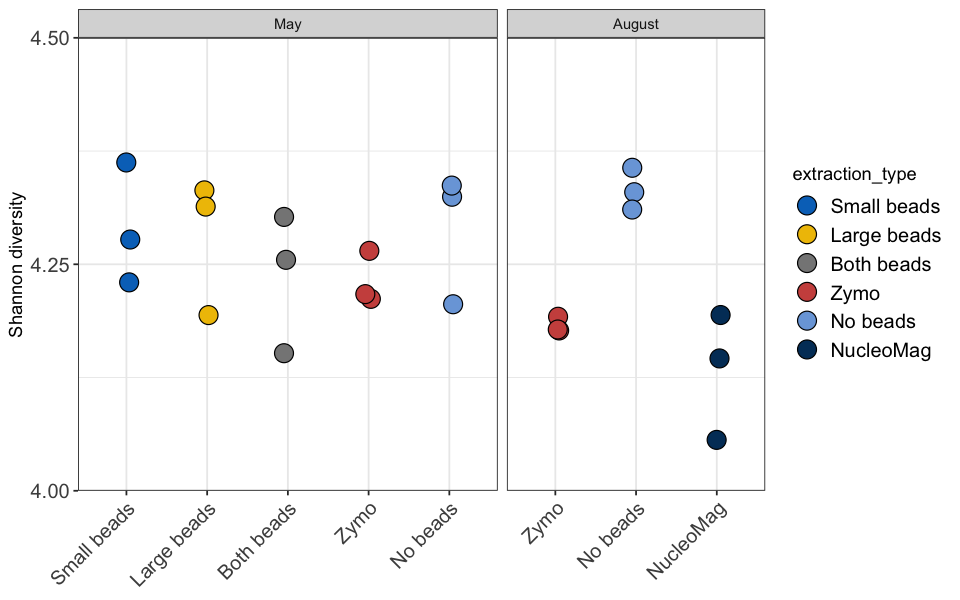

In [13]:
Shan_16S <- ggplot(alpha_16S, aes(x=extraction_type, y = Shannon, fill = extraction_type))
Shan_16S + geom_point(aes(fill = extraction_type),size = 5, shape = 21, colour = "black", position = position_jitterdodge(dodge.width=0.25)) +
   labs(y="Shannon diversity") +
   scale_fill_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF")) +theme_bw() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size=12)) + 
   theme(axis.text.y = element_text(size=12))+ theme(legend.text = element_text(colour="black", size=12))+
   theme(axis.title.x = element_blank())+scale_y_continuous(expand = c(0, 0), breaks=seq(4,4.5,0.25), limits=c(4, 4.5))  + facet_grid(~factor(extraction_day, levels = c("May", "August")), scale = "free", space = "free")

#ggsave(filename="16S_Shannon.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 4, dpi = 300)

Test the richness and Shannon data for normality.

In [12]:
shapiro.test(alpha_16S$Observed)
shapiro.test(alpha_16S$Shannon)


	Shapiro-Wilk normality test

data:  alpha_16S$Observed
W = 0.92771, p-value = 0.08664



	Shapiro-Wilk normality test

data:  alpha_16S$Shannon
W = 0.94807, p-value = 0.246


ANOVA test with Tukey post-hoc for significant differences (p < 0.05) in richness and Shannon diversity between extraction types for May or August samples. 

In [21]:
may.aov <- aov(Observed~ extraction_type, data = alpha_16S_may)
TukeyHSD(may.aov)
may.aov <- aov(Shannon~ extraction_type, data = alpha_16S_may)
TukeyHSD(may.aov)

aug.aov <- aov(Observed~ extraction_type, data = alpha_16S_aug)
TukeyHSD(aug.aov)
aug.aov <- aov(Shannon~ extraction_type, data = alpha_16S_aug)
TukeyHSD(aug.aov)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Observed ~ extraction_type, data = alpha_16S_may)

$extraction_type
                             diff       lwr      upr     p adj
Large beads-Small beads 102.33333 -378.0880 582.7547 0.9516219
Both beads-Small beads    8.00000 -472.4214 488.4214 0.9999976
Zymo-Small beads         60.00000 -420.4214 540.4214 0.9930380
No beads-Small beads     49.33333 -431.0880 529.7547 0.9967056
Both beads-Large beads  -94.33333 -574.7547 386.0880 0.9634954
Zymo-Large beads        -42.33333 -522.7547 438.0880 0.9981790
No beads-Large beads    -53.00000 -533.4214 427.4214 0.9956605
Zymo-Both beads          52.00000 -428.4214 532.4214 0.9959662
No beads-Both beads      41.33333 -439.0880 521.7547 0.9983409
No beads-Zymo           -10.66667 -491.0880 469.7547 0.9999923


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Shannon ~ extraction_type, data = alpha_16S_may)

$extraction_type
                                 diff        lwr       upr     p adj
Large beads-Small beads -0.0101904330 -0.1888508 0.1684700 0.9996701
Both beads-Small beads  -0.0535768676 -0.2322373 0.1250835 0.8553341
Zymo-Small beads        -0.0586822803 -0.2373427 0.1199781 0.8122346
No beads-Small beads    -0.0008177229 -0.1794781 0.1778427 1.0000000
Both beads-Large beads  -0.0433864346 -0.2220468 0.1352740 0.9250011
Zymo-Large beads        -0.0484918473 -0.2271523 0.1301686 0.8930584
No beads-Large beads     0.0093727101 -0.1692877 0.1880331 0.9997631
Zymo-Both beads         -0.0051054127 -0.1837658 0.1735550 0.9999789
No beads-Both beads      0.0527591447 -0.1259013 0.2314196 0.8617730
No beads-Zymo            0.0578645573 -0.1207959 0.2365250 0.8194522


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Observed ~ extraction_type, data = alpha_16S_aug)

$extraction_type
                        diff        lwr       upr     p adj
No beads-Zymo       150.3333  -97.88314 398.54980 0.2304748
NucleoMag-Zymo     -150.6667 -398.88314  97.54980 0.2292953
NucleoMag-No beads -301.0000 -549.21647 -52.78353 0.0229626


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Shannon ~ extraction_type, data = alpha_16S_aug)

$extraction_type
                          diff         lwr         upr     p adj
No beads-Zymo       0.14983195  0.04253107  0.25713283 0.0122607
NucleoMag-Zymo     -0.05026922 -0.15757010  0.05703166 0.3820199
NucleoMag-No beads -0.20010117 -0.30740205 -0.09280029 0.0029858


Remove the 16S singletons or ASVs that are only observed once across the dataset.

In [11]:
ps_rarefy_16S = filter_taxa(ps_rarefy_16S, function (x) {sum(x) > 1}, prune=TRUE)

Run ordination and plot PCoA based on weighted unifrac distances for 16S May and August bead samples. 

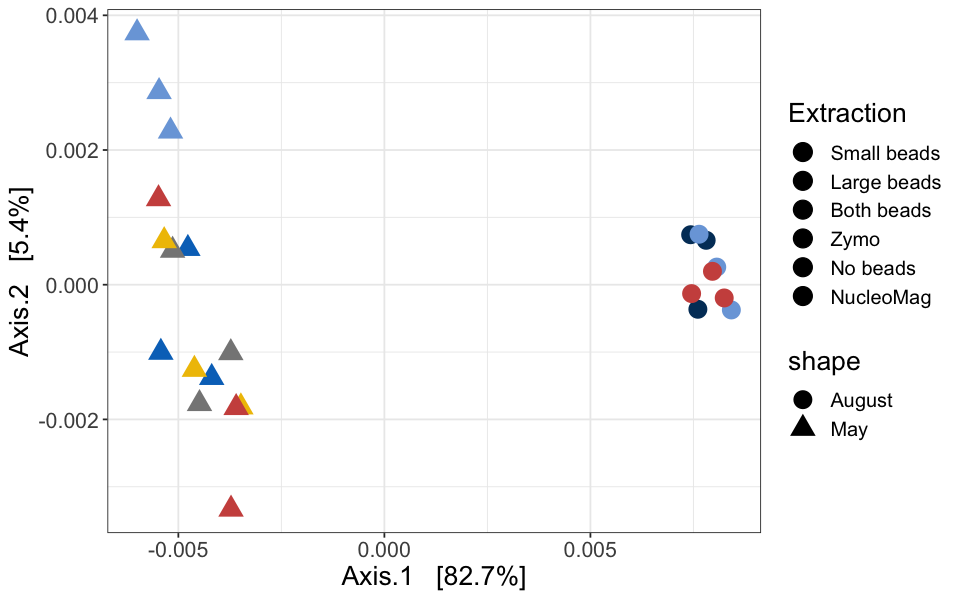

In [15]:
ps_16S_rel <- transform_sample_counts(ps_rarefy_16S,  function(x)100* x / sum(x))
ps_16S_ord <- ordinate(ps_16S_rel, "PCoA", "unifrac", weighted = TRUE)
p_beta = plot_ordination(ps_16S_rel, ps_16S_ord, color="Extraction") + guides(color=FALSE)
p_beta$data$Extraction <- factor(p_beta$data$Extraction, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads", "NucleoMag"))
p_beta + theme_bw() + theme(text = element_text(size = 16)) + geom_point(aes(fill=Extraction, shape = Day),size = 5) + 
   scale_color_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF")) + 
   theme(legend.text = element_text(colour="black", size=12))

#ggsave(filename="16S_pcoa_days.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 7, height =4 , dpi = 300)

Run PERMANOVA to test significant differences (p < 0.05) in clustering based on bead treatment and sampling day for 16S.

In [16]:
perm_May <- subset_samples(ps_16S_rel, Day != "August")# Run May first - bead treatment.
metadata <- as(sample_data(perm_May), "data.frame")
adonis(phyloseq::distance(perm_May, method="bray") ~ Extraction, data = metadata)

perm_Aug <- subset_samples(ps_16S_rel, Day != "May")# Run August - bead treatment.
metadata <- as(sample_data(perm_Aug), "data.frame")
adonis(phyloseq::distance(perm_Aug, method="bray") ~ Extraction, data = metadata)

metadata <- as(sample_data(ps_16S_rel), "data.frame") # Both days included - sampling day.
adonis(phyloseq::distance(ps_16S_rel, method="bray") ~ Day, data = metadata)


Call:
adonis(formula = phyloseq::distance(perm_May, method = "bray") ~      Extraction, data = metadata) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)  
Extraction  4  0.043661 0.0109152  1.5446 0.38189  0.034 *
Residuals  10  0.070668 0.0070668         0.61811         
Total      14  0.114329                   1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Call:
adonis(formula = phyloseq::distance(perm_Aug, method = "bray") ~      Extraction, data = metadata) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)  
Extraction  2  0.016777 0.0083884  1.6068 0.34879  0.083 .
Residuals   6  0.031324 0.0052207         0.65121         
Total       8  0.048101                   1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Call:
adonis(formula = phyloseq::distance(ps_16S_rel, method = "bray") ~      Day, data = metadata) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Day        1   1.31338 1.31338  177.89 0.88994  0.001 ***
Residuals 22   0.16243 0.00738         0.11006           
Total     23   1.47581                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Find out the most relatively abundant 16S groups across May and August samples - at the family level.

In [25]:
family_16S <- tax_glom(ps_rarefy_16S, taxrank = "Family")
family_16S <- transform_sample_counts(family_16S, function(x)100* x / sum(x))
OTU <- otu_table(family_16S)
TAX <- tax_table(family_16S)[,"Family"]
Average <- as.data.frame(rowMeans(OTU))
names(Average) <- c("Mean")
Table <- merge(TAX, Average, by=0, all=TRUE)
Table$Row.names = NULL
Table <- Table[order(desc(Table$Mean)),]
head(Table)

,Family,Mean
,<fct>,<dbl>
189,Cyanobiaceae,21.964675
12,Rhodobacteraceae,12.064203
150,Flavobacteriaceae,11.647864
392,Clade_I,9.784474
391,Clade_III,7.486540
332,Rubritaleaceae,4.921611


Plot 16S taxa bar plots at the family level (>5% relative abundance) across bead treatments and days. 

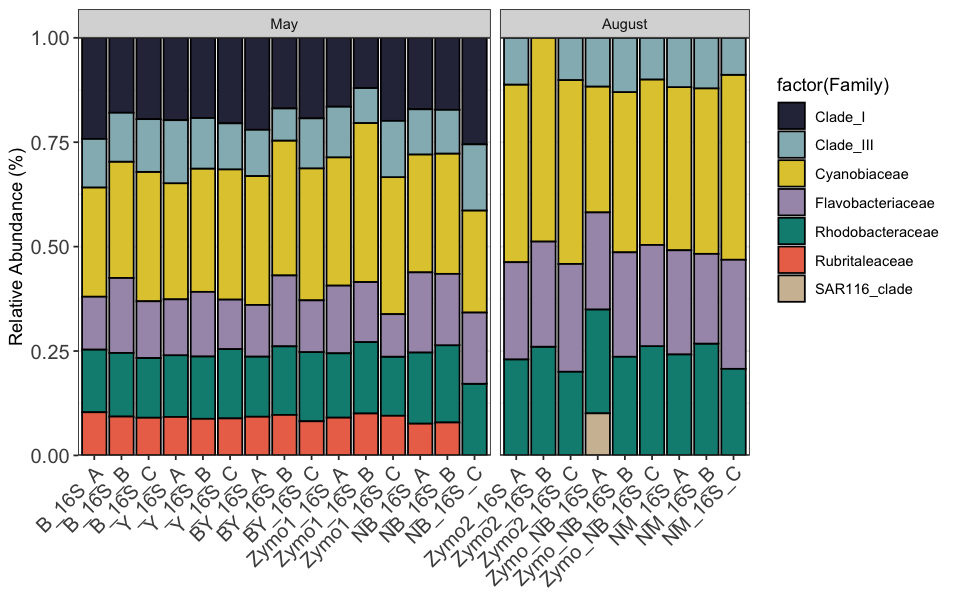

In [26]:
barplot <- ps_rarefy_16S %>%
   tax_glom(taxrank = "Family", NArm=FALSE) %>%                 # Agglomerate at family level
   transform_sample_counts(function(OTU) 100* OTU/sum(OTU)) %>% # Transform to relative abundance
   psmelt()   %>%                                               # Melt to long format
   filter(Abundance > 5)                                        # Filter out family groups <5% abundant in any sample
barplot$Family<- as.character(barplot$Family)
barplot$Day <- factor(barplot$Day, levels = c("May", "August"))
p_taxa <- ggplot(data=barplot, aes(x=Sample, y=Abundance, fill=factor(Family)))

# Set order of samples on x-axis.
p_taxa$data$Sample <- factor(p_taxa$data$Sample, levels = c("B_16S_A","B_16S_B","B_16S_C","Y_16S_A", "Y_16S_B", "Y_16S_C", "BY_16S_A", "BY_16S_B", "BY_16S_C", "Zymo1_16S_A","Zymo1_16S_B", "Zymo1_16S_C","NB_16S_A", "NB_16S_B", "NB_16S_C", "Zymo2_16S_A", "Zymo2_16S_B", "Zymo2_16S_C", "Zymo_NB_16S_A", "Zymo_NB_16S_B", "Zymo_NB_16S_C", "NM_16S_A", "NM_16S_B", "NM_16S_C"))
p_taxa + geom_bar(aes(), stat="identity", position="fill", colour="black", width = 0.9)+
   scale_y_continuous(expand = c(0, 0))+
   geom_hline(yintercept=0) + theme_bw()+ scale_fill_manual(values= c("#2E3047","#94B8BE","#E0C93B", "#A799B7", "#0A8B81", "#EB7357", "#D0BDA2"))  + 
   theme(axis.text.x=element_text(angle=45,vjust =1, hjust=1, size=12)) + theme(axis.text.y=element_text(size=12))+ 
   theme(legend.position="right") +
   guides(fill=guide_legend(nrow=11, ncol=1)) + theme(axis.title.x=element_blank())+ 
   labs(y = "Relative Abundance (%)") + facet_grid(~factor(Day, levels = c("May", "August")), scale = "free", space = "free")

#ggsave(filename="16S_bar_family.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 6, dpi = 300)

Dot plot of the top 20 most relatively abundant 16S ASVs in May. 

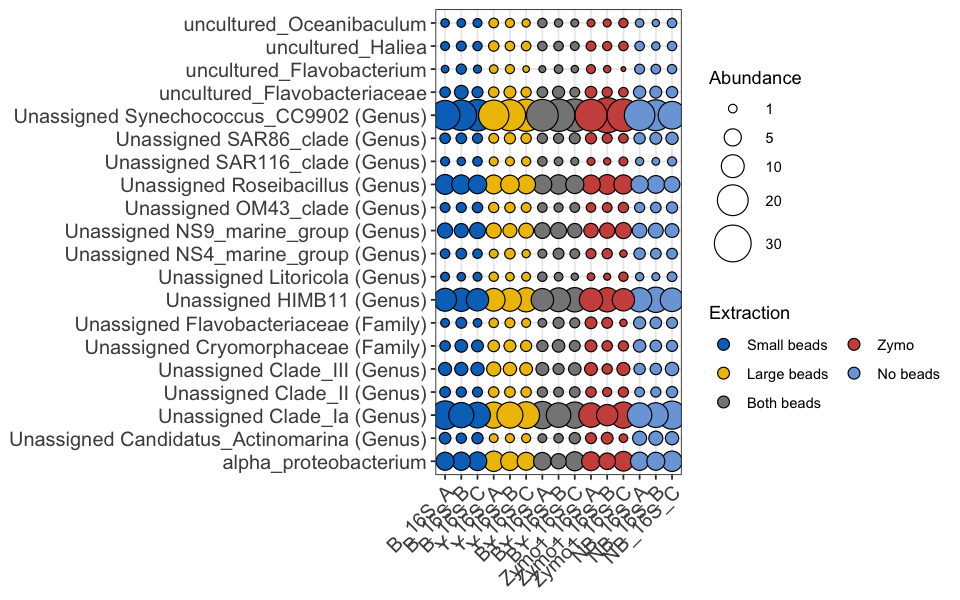

In [61]:
ps_16S_May = subset_samples(ps_rarefy_16S, Day != "August") # Isolate May samples
ps_16S_May <- name_taxa(ps_16S_May, label = "Unassigned") # Relabel Unassigned taxa
ps_16S_top <- tax_glom(ps_16S_May, taxrank = "Species", NArm=FALSE)
ps2 <-  transform_sample_counts(ps_16S_top , function(OTU) 100* OTU/sum(OTU))
P20 = prune_taxa(names(sort(taxa_sums(ps2), TRUE))[1:20], ps2) # Prune to the top 20
ps_melt <- psmelt(P20)
                        
p <- ggplot(ps_melt, aes(x=Sample, y = Species))
p$data$Extraction <- factor(p$data$Extraction, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads"))
p$data$Sample <- factor(p$data$Sample, levels = c("B_16S_A","B_16S_B","B_16S_C","Y_16S_A", "Y_16S_B", "Y_16S_C", "BY_16S_A", "BY_16S_B", "BY_16S_C", "Zymo1_16S_A","Zymo1_16S_B", "Zymo1_16S_C","NB_16S_A", "NB_16S_B", "NB_16S_C", "Zymo2_16S_A", "Zymo2_16S_B", "Zymo2_16S_C", "Zymo_NB_16S_A", "Zymo_NB_16S_B", "Zymo_NB_16S_C", "NM_16S_A", "NM_16S_B", "NM_16S_C"))
p + geom_point(aes(size=Abundance, fill= Extraction), alpha = 1, shape = 21) + theme_bw() +
  scale_fill_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF")) + 
  theme(axis.text.x=element_text(angle=45,vjust =1, hjust=1, size=12)) + theme(axis.text.y=element_text(size = 12)) +
  scale_size_continuous(limits = c(0.5730659, 30), range=c(1,10), breaks = c(1, 5, 10, 20, 30)) +
  theme(axis.title.x = element_blank(),axis.title.y = element_blank())+
  guides(fill=guide_legend(ncol=2, override.aes = list(size=3)))
                                
#ggsave(filename="top20_ASVs_16S_May.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 10, height = 6, dpi = 300)

Dot plot of the top 20 most relatively abundant 16S ASVs in August. 

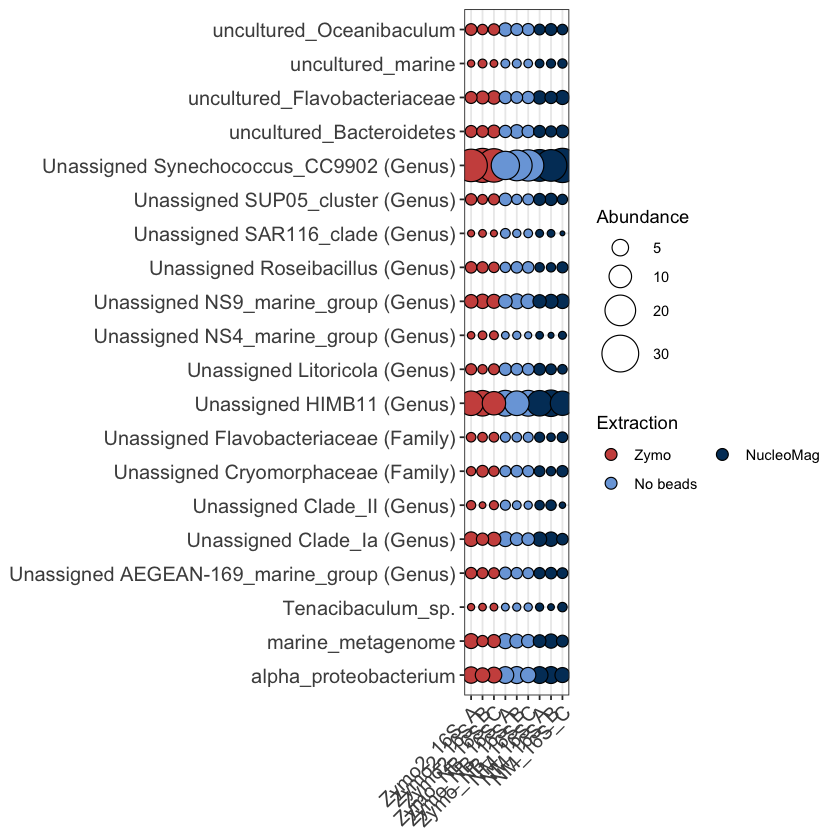

In [15]:
ps_16S_Aug = subset_samples(ps_rarefy_16S, Day != "May") 
ps_16S_Aug<- name_taxa(ps_16S_Aug, label = "Unassigned")
ps_16S_top <- tax_glom(ps_16S_Aug, taxrank = "Species", NArm=FALSE)
ps2 <-  transform_sample_counts(ps_16S_top , function(OTU) 100* OTU/sum(OTU))
P20 = prune_taxa(names(sort(taxa_sums(ps2), TRUE))[1:20], ps2)
ps_melt <- psmelt(P20)
                  
p <- ggplot(ps_melt, aes(x=Sample, y = Species))
p$data$Extraction <- factor(p$data$Extraction, levels = c("Zymo", "No beads", "NucleoMag"))
p$data$Sample <- factor(p$data$Sample, levels = c("Zymo2_16S_A", "Zymo2_16S_B", "Zymo2_16S_C", "Zymo_NB_16S_A", "Zymo_NB_16S_B", "Zymo_NB_16S_C", "NM_16S_A", "NM_16S_B", "NM_16S_C"))
p + geom_point(aes(size=Abundance, fill= Extraction), alpha = 1, shape = 21) + theme_bw() +
   scale_fill_manual(values=c("#CD534CFF", "#7AA6DCFF", "#003C67FF")) + 
   theme(axis.text.x=element_text(angle=45,vjust =1, hjust=1, size=12)) + theme(axis.text.y=element_text(size = 12)) +
   scale_size_continuous(limits = c(1.072606, 30), range=c(1,10), breaks = c(1, 5, 10, 20, 30)) +
   theme(axis.title.x = element_blank(),axis.title.y = element_blank())+
   guides(fill=guide_legend(ncol=2, override.aes = list(size=3)))

#ggsave(filename="top20_ASVs_16S_Aug.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 10, height = 6, dpi = 300)

Use ps_venn function to estimate percentage of 16S ASVs shared between bead treatments in May and August. Percent shared is estimated between all bead treatments (n=5 in May and n=3 in August) or between just the Zymo treatments (Zymo vs. no beads). We will hide the output of percent shared. 

In [35]:
invisible(capture.output(ps_venn(perm_May, group="Extraction", fraction =1, weight = FALSE, type = "percent", relative = FALSE, plot = FALSE)))
perm_May2 = subset_samples(perm_May, Extraction == "Zymo" | Extraction == "No beads")
invisible(capture.output(ps_venn(perm_May2, group="Extraction", fraction =1, weight = FALSE, type = "percent", relative = FALSE, plot = FALSE)))


invisible(capture.output(ps_venn(perm_Aug, group="Extraction", fraction =1, weight = FALSE, type = "percent", relative = FALSE, plot = FALSE)))
perm_Aug2 = subset_samples(perm_Aug, Extraction == "Zymo" | Extraction == "No beads")
invisible(capture.output(ps_venn(perm_Aug2, group="Extraction", fraction =1, weight = FALSE, type = "percent", relative = FALSE, plot = FALSE)))

Load taxonomy and count files (.qza) from QIIME 2 using the qiime2R package. Now we move on to process the 16S rRNA chloroplast reads that were assigned to photosynthetic eukaryotes. 

In [36]:
ASVs_euk <- read_qza(file="/16S-plastid/table_chloroplast.qza")
ASVs_euk <- ASVs_euk$data %>% as.data.frame()
tax_euk <- read_qza(file="/16S-plastid/asv_plastid.qza")
tax_euk <- tax_euk$data %>% 
    as.data.frame() %>%
    separate(Taxon, sep=";", c("Kingdom", "Supergroup", "Division", "Class", "Order", "Family", "Genus", "Species")) %>%
    column_to_rownames("Feature.ID") 
    tax_euk$Confidence <- NULL

# Clean up the taxonomy table: remove unassigned reads at the kingdom level. 
tax_euk<- subset(tax_euk, !grepl("Unassigned",tax_euk$Kingdom))

Warning message:
“Expected 8 pieces. Additional pieces discarded in 262 rows [4, 5, 7, 8, 9, 10, 12, 14, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 32, 33, ...].”
Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 155 rows [1, 2, 3, 6, 11, 13, 15, 16, 20, 28, 29, 30, 31, 37, 42, 43, 44, 45, 46, 47, ...].”


Load rooted phylogenetic tree for 16S chloroplasts. 

In [37]:
tree_euk <- read_qza(file="/16S-plastid/rooted-tree-chl.qza")

Merge into a phyloseq object.

In [38]:
physeq_euk <- phyloseq(otu_table(ASVs_euk, taxa_are_rows= T), tax_table(as.matrix(tax_euk)),phy_tree(tree_euk$data), sample_data(sample_info_tab))

Filter out the controls. 

In [39]:
psnew_euk = subset_samples(physeq_euk, Day != "Control")
psnew_euk = subset_samples(psnew_euk, Extraction != "MilliQ")

Plot rarefaction curve for 16S chloroplasts. 

rarefying sample B_16S_A
rarefying sample B_16S_B
rarefying sample B_16S_C
rarefying sample BY_16S_A
rarefying sample BY_16S_B
rarefying sample BY_16S_C
rarefying sample NB_16S_A
rarefying sample NB_16S_B
rarefying sample NB_16S_C
rarefying sample NM_16S_A
rarefying sample NM_16S_B
rarefying sample NM_16S_C
rarefying sample Y_16S_A
rarefying sample Y_16S_B
rarefying sample Y_16S_C
rarefying sample Zymo_NB_16S_A
rarefying sample Zymo_NB_16S_B
rarefying sample Zymo_NB_16S_C
rarefying sample Zymo1_16S_A
rarefying sample Zymo1_16S_B
rarefying sample Zymo1_16S_C
rarefying sample Zymo2_16S_A
rarefying sample Zymo2_16S_B
rarefying sample Zymo2_16S_C


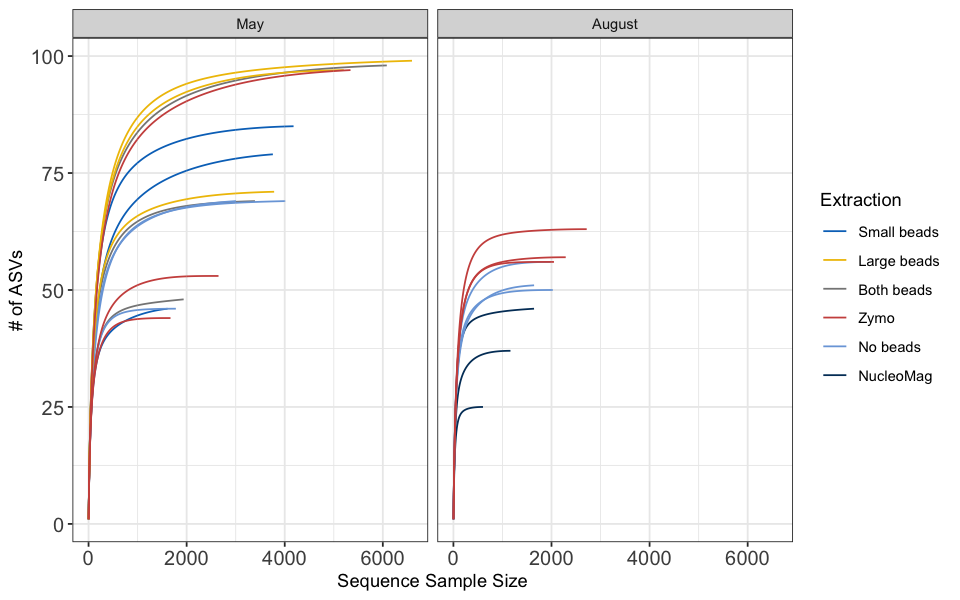

In [28]:
rare_euk <- ggrare(psnew_euk, step = 10, plot = FALSE, parallel = FALSE, se = FALSE, color = "Extraction")
rare_euk$data$Extraction <- factor(rare_euk$data$Extraction, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads", "NucleoMag"))
rare_euk + theme(legend.position = "none") + theme_bw()+ facet_grid(~factor(Day, levels = c("May", "August")), scales="free_y") +
labs(y="# of ASVs")+ theme(axis.text.x=element_text(size=12))+ theme(axis.text.y=element_text(size=12))+
scale_color_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF"))

#ggsave(filename="Chl_rarefaction.pdf", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 4, dpi = 300)

Calculate mean, max and min sequence read counts for 16S chloroplasts across all samples. 

In [29]:
euk_min <- min(sample_sums(psnew_euk))
euk_mean <- mean(sample_sums(psnew_euk))
euk_max <- max(sample_sums(psnew_euk))

Rarefy to an even sampling depth (minimum read count in dataset). 

In [40]:
suppressMessages(ps_rarefy_euk <- rarefy_even_depth(psnew_euk, sample.size = min(sample_sums(psnew_euk)), rngseed = 714, replace = TRUE, trimOTUs = TRUE, verbose = TRUE))

Estimate observed ASV richness and Shannon diversity (for 16S chloroplasts) and combine in new data frame with specific metadata factors from the phyloseq object (extraction type and sampling day). 

In [31]:
extraction_type = sample_data(ps_rarefy_euk)$Extraction
extraction_day = sample_data(ps_rarefy_euk)$Day
alpha_euk <- estimate_richness(ps_rarefy_euk, measures=c("Shannon", "Observed")) %>%
cbind(extraction_type, extraction_day)

Plot species richness (# of ASVs) for 16S chloroplasts across bead treatments and sampling days. 

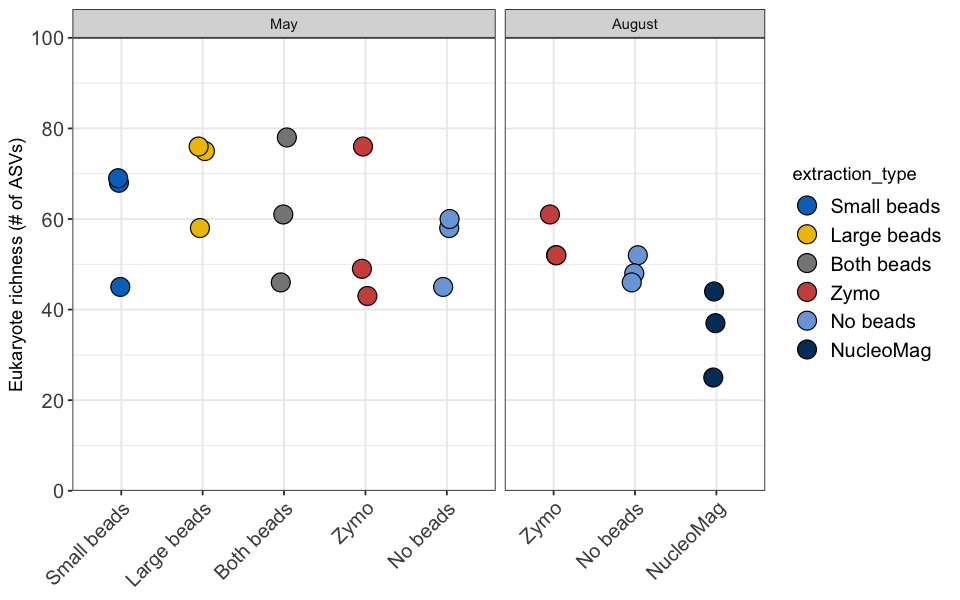

In [32]:
alpha_euk$extraction_type <- factor(alpha_euk$extraction_type, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads", "NucleoMag"))
Rich_euk <- ggplot(alpha_euk, aes(x=extraction_type, y = Observed, fill = extraction_type))
Rich_euk + geom_point(aes(fill = extraction_type),size = 5, shape = 21, colour = "black", position = position_jitterdodge(dodge.width=0.25)) +
   labs(y="Eukaryote richness (# of ASVs)") +
   scale_fill_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF")) +theme_bw() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size=12)) + 
   theme(axis.text.y = element_text(size=12))+ theme(legend.text = element_text(colour="black", size=12))+
   theme(axis.title.x = element_blank())+scale_y_continuous(expand = c(0, 0), breaks=seq(0,100,20), limits=c(0, 100))  + facet_grid(~factor(extraction_day, levels = c("May", "August")), scale = "free", space = "free")

#ggsave(filename="Chl_Observed.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 4, dpi = 300)

Plot Shannon diversity for 16S chloroplasts across bead treatments and sampling days. 

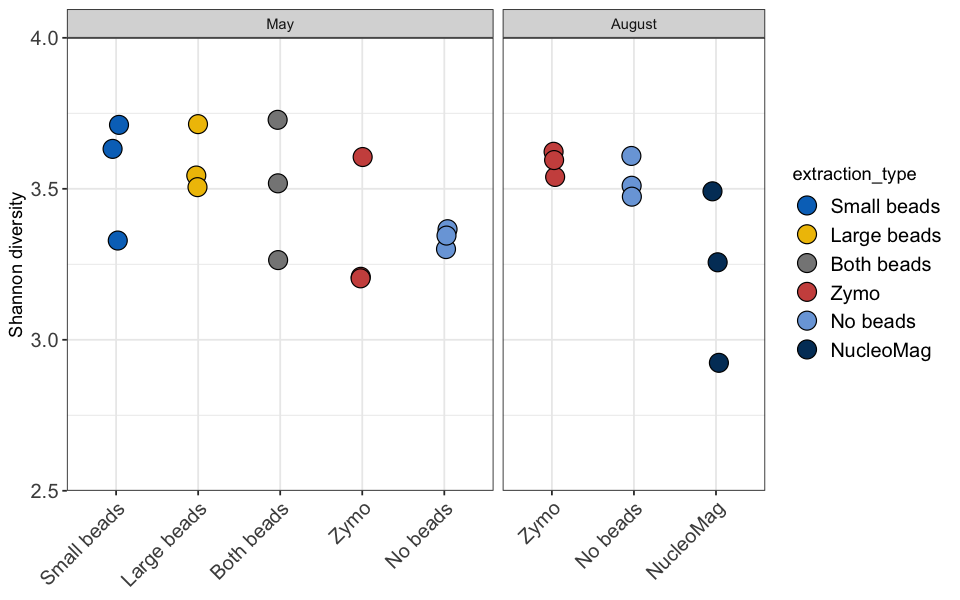

In [33]:
alpha_euk$extraction_type <- factor(alpha_euk$extraction_type, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads", "NucleoMag"))
Shan_euk <- ggplot(alpha_euk, aes(x=extraction_type, y = Shannon, fill = extraction_type))
Shan_euk + geom_point(aes(fill = extraction_type),size = 5, shape = 21, colour = "black", position = position_jitterdodge(dodge.width=0.25)) +
   labs(y="Shannon diversity") +
   scale_fill_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF")) +theme_bw() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size=12)) + 
   theme(axis.text.y = element_text(size=12))+ theme(legend.text = element_text(colour="black", size=12))+
   theme(axis.title.x = element_blank())+scale_y_continuous(expand = c(0, 0), breaks=seq(2.5,4,0.5), limits=c(2.5, 4))  + facet_grid(~factor(extraction_day, levels = c("May", "August")), scale = "free", space = "free")

#ggsave(filename="Chl_Shannon.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 4, dpi = 300)

Test normality of the data. 

In [20]:
shapiro.test(alpha_euk$Observed)
shapiro.test(alpha_euk$Shannon)


	Shapiro-Wilk normality test

data:  alpha_euk$Observed
W = 0.9556, p-value = 0.3566



	Shapiro-Wilk normality test

data:  alpha_euk$Shannon
W = 0.93417, p-value = 0.1209


ANOVA test with Tukey post-hoc for significant differences (p < 0.05) in richness and Shannon diversity between extraction types for May or August samples. 

In [39]:
alpha_euk_may <- subset(alpha_euk, !grepl("August",alpha_euk$extraction_day))
may.aov <- aov(Observed~ extraction_type, data = alpha_euk_may)
TukeyHSD(may.aov)
may.aov <- aov(Shannon~ extraction_type, data = alpha_euk_may)
TukeyHSD(may.aov)

alpha_euk_aug <- subset(alpha_euk, !grepl("May",alpha_euk$extraction_day))
aug.aov <- aov(Observed~ extraction_type, data = alpha_euk_aug)
TukeyHSD(aug.aov)
aug.aov <- aov(Shannon~ extraction_type, data = alpha_euk_aug)
TukeyHSD(aug.aov)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Observed ~ extraction_type, data = alpha_euk_may)

$extraction_type
                              diff       lwr      upr     p adj
Large beads-Both beads    8.000000 -28.41734 44.41734 0.9462731
No beads-Both beads      -7.333333 -43.75068 29.08401 0.9601406
Small beads-Both beads   -1.000000 -37.41734 35.41734 0.9999820
Zymo-Both beads          -5.666667 -42.08401 30.75068 0.9841738
No beads-Large beads    -15.333333 -51.75068 21.08401 0.6492170
Small beads-Large beads  -9.000000 -45.41734 27.41734 0.9206015
Zymo-Large beads        -13.666667 -50.08401 22.75068 0.7329208
Small beads-No beads      6.333333 -30.08401 42.75068 0.9762783
Zymo-No beads             1.666667 -34.75068 38.08401 0.9998621
Zymo-Small beads         -4.666667 -41.08401 31.75068 0.9923268


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Shannon ~ extraction_type, data = alpha_euk_may)

$extraction_type
                                diff        lwr       upr     p adj
Large beads-Both beads   0.084370322 -0.3986608 0.5674015 0.9759039
No beads-Both beads     -0.166267249 -0.6492984 0.3167639 0.7865724
Small beads-Both beads   0.054045558 -0.4289856 0.5370767 0.9954194
Zymo-Both beads         -0.164397430 -0.6474286 0.3186337 0.7929863
No beads-Large beads    -0.250637571 -0.7336687 0.2323936 0.4709979
Small beads-Large beads -0.030324764 -0.5133559 0.4527064 0.9995181
Zymo-Large beads        -0.248767752 -0.7317989 0.2342634 0.4776969
Small beads-No beads     0.220312807 -0.2627183 0.7033440 0.5839721
Zymo-No beads            0.001869819 -0.4811613 0.4849010 1.0000000
Zymo-Small beads        -0.218442988 -0.7014741 0.2645882 0.5911519


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Observed ~ extraction_type, data = alpha_euk_aug)

$extraction_type
                         diff        lwr       upr     p adj
NucleoMag-No beads -13.333333 -29.740023  3.073357 0.1029251
Zymo-No beads        6.333333 -10.073357 22.740023 0.5034717
Zymo-NucleoMag      19.666667   3.259977 36.073357 0.0241256


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Shannon ~ extraction_type, data = alpha_euk_aug)

$extraction_type
                          diff        lwr       upr     p adj
NucleoMag-No beads -0.30695547 -0.7363008 0.1223898 0.1509095
Zymo-No beads       0.05472583 -0.3746195 0.4840711 0.9202315
Zymo-NucleoMag      0.36168129 -0.0676640 0.7910266 0.0916475


Remove the 16S chloroplast singletons or ASVs that are only observed once across the dataset.

In [41]:
ps_rarefy_euk = filter_taxa(ps_rarefy_euk, function (x) {sum(x) > 1}, prune=TRUE)

Run ordination and plot PCoA based on weighted unifrac distances for 16S chloroplasts May and August bead samples. 

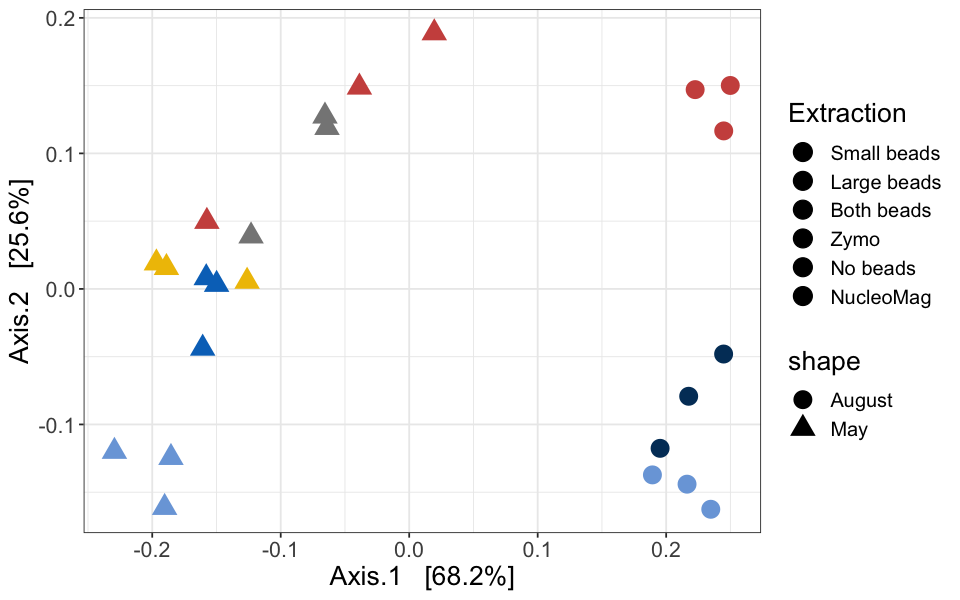

In [42]:
ps_euk_rel <- transform_sample_counts(ps_rarefy_euk, function(x)100* x / sum(x))
ps_euk_ord <- ordinate(ps_euk_rel, "PCoA", "unifrac", weighted = TRUE)
p_beta = plot_ordination(ps_euk_rel, ps_euk_ord, color="Extraction") + guides(color=FALSE)
p_beta$data$Extraction <- factor(p_beta$data$Extraction, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads", "NucleoMag"))
p_beta + theme_bw() + theme(text = element_text(size = 16)) + geom_point(aes(fill=Extraction, shape = Day),size = 5) + 
   scale_color_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF")) + 
   theme(legend.text = element_text(colour="black", size=12))

#ggsave(filename="Chl_pcoa_days.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 7, height = 4, dpi = 300)

Run PERMANOVA to test significant differences (p < 0.05) in clustering based on bead treatment and sampling day for 16S chloroplasts.

In [43]:
perm_May <- subset_samples(ps_euk_rel, Day != "August")# Run May first - bead treatment.
metadata <- as(sample_data(perm_May), "data.frame")
adonis(phyloseq::distance(perm_May, method="bray") ~ Extraction, data = metadata)

perm_Aug <- subset_samples(ps_euk_rel, Day != "May")# Run August - bead treatment.
metadata <- as(sample_data(perm_Aug), "data.frame")
adonis(phyloseq::distance(perm_Aug, method="bray") ~ Extraction, data = metadata)

metadata <- as(sample_data(ps_euk_rel), "data.frame") # Both days included - sampling days.
adonis(phyloseq::distance(ps_euk_rel, method="bray") ~ Day, data = metadata)


Call:
adonis(formula = phyloseq::distance(perm_May, method = "bray") ~      Extraction, data = metadata) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Extraction  4   0.61963 0.154908  3.2615 0.56609  0.001 ***
Residuals  10   0.47496 0.047496         0.43391           
Total      14   1.09459                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Call:
adonis(formula = phyloseq::distance(perm_Aug, method = "bray") ~      Extraction, data = metadata) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)   
Extraction  2   0.57145 0.285723   5.168 0.63271  0.005 **
Residuals   6   0.33172 0.055287         0.36729          
Total       8   0.90317                  1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Call:
adonis(formula = phyloseq::distance(ps_euk_rel, method = "bray") ~      Day, data = metadata) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Day        1    1.9793 1.97933  21.797 0.49768  0.001 ***
Residuals 22    1.9978 0.09081         0.50232           
Total     23    3.9771                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Find out the most relatively abundant 16S chloroplast groups (photosynthetic eukaryotes) across May and August samples - at the class level.

In [61]:
class_euk <- tax_glom(ps_rarefy_euk, taxrank = "Class")
class_euk <- transform_sample_counts(class_euk, function(x)100* x / sum(x))
OTU <- otu_table(class_euk)
TAX <- tax_table(class_euk)[,"Class"]
Average <- as.data.frame(rowMeans(OTU))
names(Average) <- c("Mean")
Table <- merge(TAX, Average, by=0, all=TRUE)
Table$Row.names = NULL
Table <- Table[order(desc(Table$Mean)),]
head(Table)

,Class,Mean
,<fct>,<dbl>
20,Mamiellophyceae,25.112235
7,Prymnesiophyceae,18.794005
19,Bacillariophyta,13.070587
17,Eustigmatophyceae,7.634948
8,Cryptophyceae,7.608213
4,Chlorarachniophyceae,6.297925


Plot taxa bar plots at the class level (>5% relative abundance) for eukaryotes across bead treatments and days.

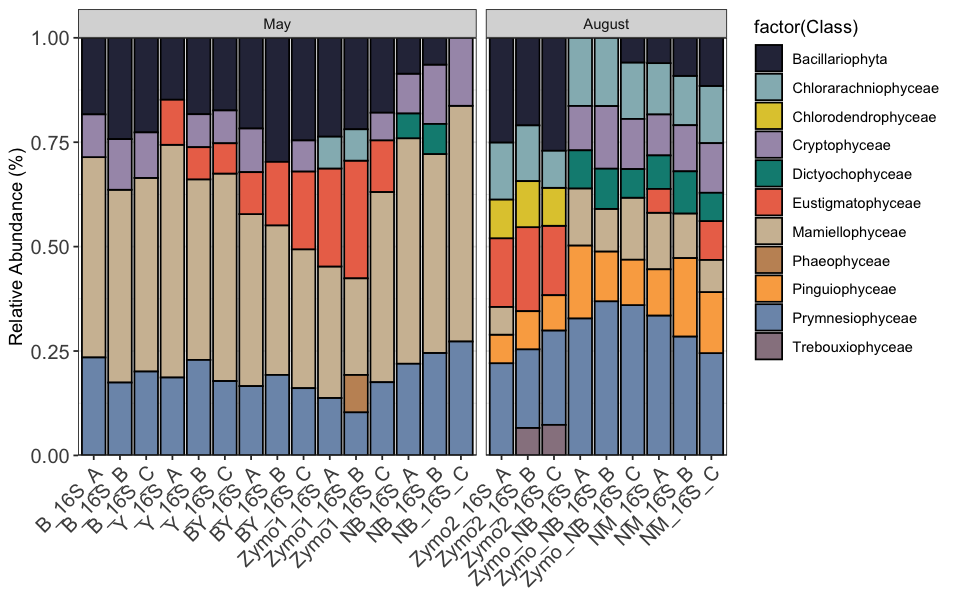

In [62]:
barplot_euk <- ps_rarefy_euk %>%
   tax_glom(taxrank = "Class", NArm=FALSE) %>%                  # Agglomerate at class level
   transform_sample_counts(function(OTU) 100* OTU/sum(OTU)) %>% # Transform to relative abundance
   psmelt()   %>%                                               # Melt to long format
   filter(Abundance > 5)                                        # Filter out any class <5% of relative abundance in a given sample
barplot_euk$Class<- as.character(barplot_euk$Class)
barplot_euk$Day <- factor(barplot_euk$Day, levels = c("May", "August"))
p_taxa_euk <- ggplot(data=barplot_euk, aes(x=Sample, y=Abundance, fill=factor(Class)))

# Set order of samples on x-axis.
p_taxa_euk$data$Sample <- factor(p_taxa_euk$data$Sample, levels = c("B_16S_A","B_16S_B","B_16S_C","Y_16S_A", "Y_16S_B", "Y_16S_C", "BY_16S_A", "BY_16S_B", "BY_16S_C", "Zymo1_16S_A","Zymo1_16S_B", "Zymo1_16S_C","NB_16S_A", "NB_16S_B", "NB_16S_C", "Zymo2_16S_A", "Zymo2_16S_B", "Zymo2_16S_C", "Zymo_NB_16S_A", "Zymo_NB_16S_B", "Zymo_NB_16S_C", "NM_16S_A", "NM_16S_B", "NM_16S_C"))
p_taxa_euk + geom_bar(aes(), stat="identity", position="fill", colour="black", width = 0.9)+
   scale_y_continuous(expand = c(0, 0))+
   geom_hline(yintercept=0) + theme_bw()+ scale_fill_manual(values= c("#2E3047","#94B8BE","#E0C93B", "#A799B7", "#0A8B81", "#EB7357", "#D0BDA2", "#C49264", "#FAAB50", "#7D97B8", "#98838F"))  + 
   theme(axis.text.x=element_text(angle=45,vjust =1, hjust=1, size=12)) + theme(axis.text.y=element_text(size=12))+ 
   theme(legend.position="right") +
   guides(fill=guide_legend(nrow=15, ncol=1)) + theme(axis.title.x=element_blank())+ 
   labs(y = "Relative Abundance (%)") + facet_grid(~factor(Day, levels = c("May", "August")), scale = "free", space = "free")

#ggsave(filename="Chl_bar_class.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 6, dpi = 300)

Dot plot of the top 20 most relatively abundant 16S chloroplast ASVs in May.

Warning message:
“Removed 17 rows containing missing values (geom_point).”


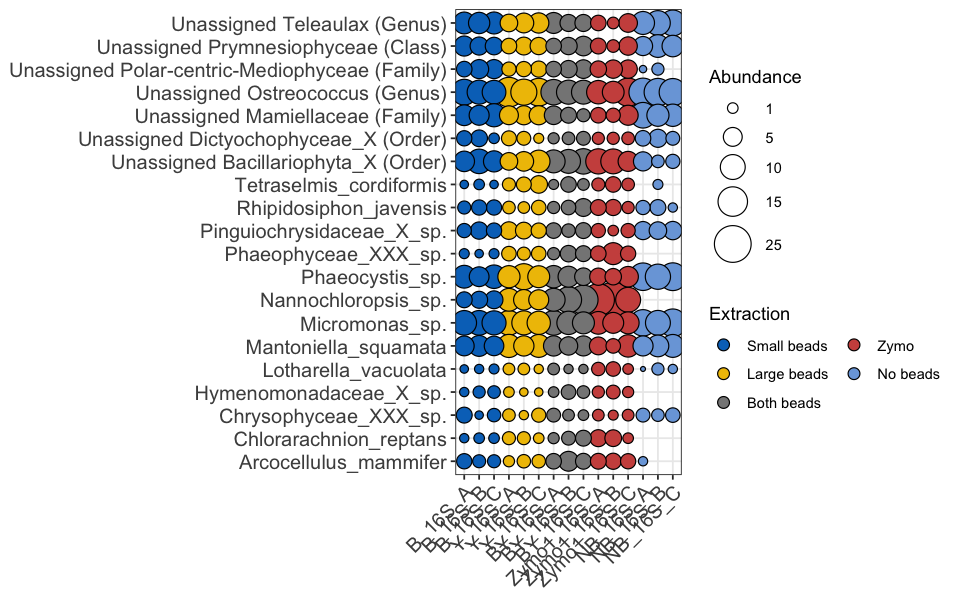

In [63]:
ps_euk_May = subset_samples(ps_rarefy_euk, Day != "August") 
ps_euk_May <- name_taxa(ps_euk_May, label = "Unassigned")
ps_euk_top <- tax_glom(ps_euk_May, taxrank = "Species", NArm=FALSE)
ps2 <-  transform_sample_counts(ps_euk_top , function(OTU) 100* OTU/sum(OTU))
P20 = prune_taxa(names(sort(taxa_sums(ps2), TRUE))[1:20], ps2)
ps_melt <- psmelt(P20)
                                
p <- ggplot(ps_melt, aes(x=Sample, y = Species))
p$data$Extraction <- factor(p$data$Extraction, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads"))
p$data$Sample <- factor(p$data$Sample, levels = c("B_16S_A","B_16S_B","B_16S_C","Y_16S_A", "Y_16S_B", "Y_16S_C", "BY_16S_A", "BY_16S_B", "BY_16S_C", "Zymo1_16S_A","Zymo1_16S_B", "Zymo1_16S_C","NB_16S_A", "NB_16S_B", "NB_16S_C", "Zymo2_16S_A", "Zymo2_16S_B", "Zymo2_16S_C", "Zymo_NB_16S_A", "Zymo_NB_16S_B", "Zymo_NB_16S_C", "NM_16S_A", "NM_16S_B", "NM_16S_C"))
p + geom_point(aes(size=Abundance, fill= Extraction), alpha = 1, shape = 21) + theme_bw() +
   scale_fill_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF")) + 
   theme(axis.text.x=element_text(angle=45,vjust =1, hjust=1, size=12)) +theme(axis.text.y=element_text(size =12))+
   scale_size_continuous(limits = c(0.1666667, 25), range=c(1,10), breaks = c(1, 5, 10, 15, 25)) +
   theme(axis.title.x = element_blank(),axis.title.y = element_blank())+
   guides(fill=guide_legend(ncol=2, override.aes = list(size=3)))

#ggsave(filename="top20_ASVs_Chl_May.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 10, height = 6, dpi = 300)

Dot plot of the top 20 most relatively abundant 16S chloroplast ASVs in August.

Warning message:
“Removed 16 rows containing missing values (geom_point).”


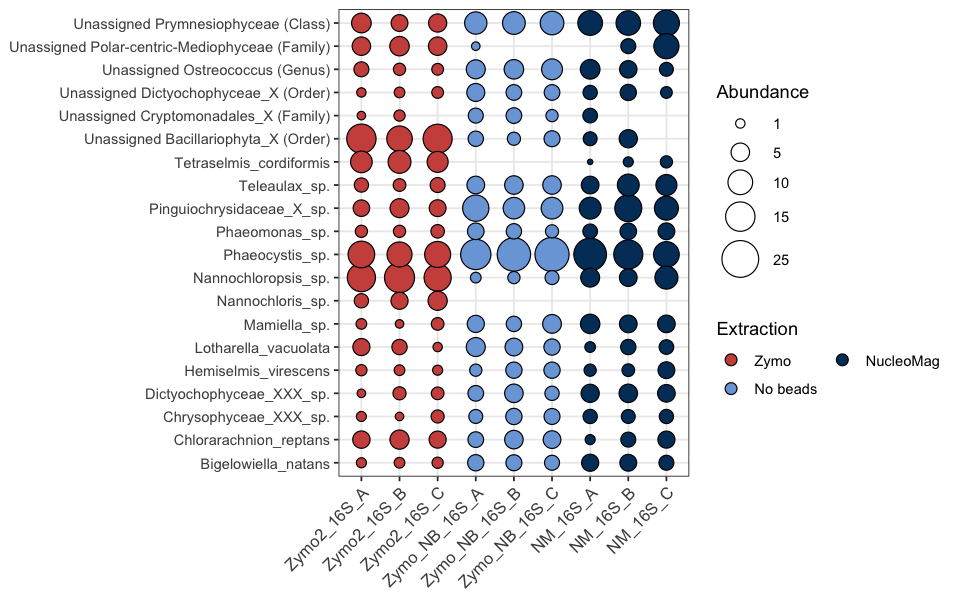

In [64]:
ps_euk_Aug = subset_samples(ps_rarefy_euk, Day != "May") 
ps_euk_Aug<- name_taxa(ps_euk_Aug, label = "Unassigned")
ps_euk_top <- tax_glom(ps_euk_Aug, taxrank = "Species", NArm=FALSE)
ps2 <-  transform_sample_counts(ps_euk_top , function(OTU) 100* OTU/sum(OTU))
P20 = prune_taxa(names(sort(taxa_sums(ps2), TRUE))[1:20], ps2)
ps_melt <- psmelt(P20)
 
p <- ggplot(ps_melt, aes(x=Sample, y = Species))
p$data$Extraction <- factor(p$data$Extraction, levels = c( "Zymo", "No beads", "NucleoMag"))
p$data$Sample <- factor(p$data$Sample, levels = c("Zymo2_16S_A", "Zymo2_16S_B", "Zymo2_16S_C", "Zymo_NB_16S_A", "Zymo_NB_16S_B", "Zymo_NB_16S_C", "NM_16S_A", "NM_16S_B", "NM_16S_C"))
p + geom_point(aes(size=Abundance, fill= Extraction), alpha = 1, shape = 21) + theme_bw() +
   scale_fill_manual(values=c("#CD534CFF", "#7AA6DCFF", "#003C67FF")) + 
   theme(axis.text.x=element_text(angle=45,vjust =1, hjust=1, size=10)) +
   scale_size_continuous(limits = c(0.4891681, 25), range=c(1,10), breaks = c(1, 5, 10,15, 25)) +
   theme(axis.title.x = element_blank(),axis.title.y = element_blank())+
   guides(fill=guide_legend(ncol=2, override.aes = list(size=3)))

#ggsave(filename="top20_ASVs_Chl_Aug.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 9, height = 6, dpi = 300)

Use ps_venn function to estimate percentage of 16S chloroplast ASVs shared between bead treatments in May and August.

In [44]:
invisible(capture.output(ps_venn(perm_May, group="Extraction", fraction =1, weight = FALSE, type = "percent", relative = FALSE, plot = FALSE)))    
perm_May2 = subset_samples(perm_May, Extraction == "Zymo" | Extraction == "No beads")
invisible(capture.output(ps_venn(perm_May2, group="Extraction", fraction =1, weight = FALSE, type = "percent", relative = FALSE, plot = FALSE)))


invisible(capture.output(ps_venn(perm_Aug, group="Extraction", fraction =1, weight = FALSE, type = "percent", relative = FALSE, plot = FALSE))) 
perm_Aug2 = subset_samples(perm_Aug, Extraction == "Zymo" | Extraction == "No beads")
invisible(capture.output(ps_venn(perm_Aug2, group="Extraction", fraction =1, weight = FALSE, type = "percent", relative = FALSE, plot = FALSE)))

Load taxonomy and count files (.qza) from QIIME 2 using the qiime2R package. Now we move on to process the 12S rRNA data targeting bony fishes.

In [76]:
ASVs_12S <- read_qza(file="/12S/table-12S-vsearch.qza") 
ASVs_12S <- ASVs_12S$data %>% as.data.frame()
tax_12S <- read_qza(file="/12S/12S-class-vsearch.qza")
tax_12S <- tax_12S$data %>% 
    as.data.frame() %>%
    separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>%
    column_to_rownames("Feature.ID") 
Seqs_12S <- read_qza(file="/12S/rep-seqs-12S-vsearch.qza")
Seqs_12S <- Seqs_12S$data %>% as.data.frame() # Include representative sequences file

# Merge with taxonomy and export to create Table S1, showing top 40 fish taxa included in our poll.
merge_12S = cbind(tax_12S, Seqs_12S)
merge_12S<- subset(merge_12S, !grepl("Unassigned",merge_12S$Kingdom))
#write.csv(merge_12S, file="merged_12S_05102021.csv", row.names=T)

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 812 rows [1, 2, 3, 5, 6, 9, 10, 11, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, ...].”


Clean up the taxonomy table; remove unassigned reads at the kingdom level and relabel taxa to remove unnecessary text. 

In [77]:
tax_12S <- subset(tax_12S, !grepl("Unassigned",tax_12S$Kingdom))
tax_12S$Kingdom <- gsub("^.{0,3}", "", tax_12S$Kingdom)
tax_12S$Phylum <- gsub("^.{0,4}", "", tax_12S$Phylum)
tax_12S$Class <- gsub("^.{0,4}", "", tax_12S$Class)
tax_12S$Order <- gsub("^.{0,4}", "", tax_12S$Order)
tax_12S$Family <- gsub("^.{0,4}", "", tax_12S$Family)
tax_12S$Genus <- gsub("^.{0,4}", "", tax_12S$Genus)
tax_12S$Species <- gsub("^.{0,4}", "", tax_12S$Species)
tax_12S$Consensus <- NULL

Load rooted phylogenetic tree file for 12S.

In [78]:
tree_12S <- read_qza(file="/12S/rooted-tree-vsearch.qza")
tree <- tree_12S$data
new_tree <-ape::multi2di(tree)

Load metadata file for 12S samples.

In [79]:
sample_info_tab <- read_tsv(file="/12S/metadata.tsv")
sample_info_tab <- sample_data(sample_info_tab)
rownames(sample_info_tab) <- sample_info_tab$sample_name

Parsed with column specification:
cols(
  sample_name = col_character(),
  Day = col_character(),
  Extraction = col_character(),
  Temp = col_double(),
  Salinity = col_double(),
  quant_reading = col_double(),
  Sample_or_Control = col_character(),
  Replicate = col_character()
)



Merge everything into a phyloseq object.

In [80]:
physeq_12S <- phyloseq(otu_table(ASVs_12S, taxa_are_rows= T), tax_table(as.matrix(tax_12S)), phy_tree(new_tree), sample_data(sample_info_tab))

Remove negative control sample and Milli-Q. 

In [81]:
psnew_12S = subset_samples(physeq_12S, Day != "Control")
psnew_12S = subset_samples(psnew_12S, Extraction != "MilliQ")

Subset the bacteria reads from fish - we will look at bacteria later to compare to the 16S rRNA profiles.

In [82]:
psnew_fish <- subset_taxa(psnew_12S, Kingdom != "Bacteria")
psnew_bact <- subset_taxa(psnew_12S, Kingdom == "Bacteria")

Plot rarefaction curves for 12S. 

rarefying sample B_12S_A
rarefying sample B_12S_B
rarefying sample B_12S_C
rarefying sample BY_12S_A
rarefying sample BY_12S_B
rarefying sample BY_12S_C
rarefying sample NB_12S_A
rarefying sample NB_12S_B
rarefying sample NB_12S_C
rarefying sample NM_12S_A
rarefying sample NM_12S_B
rarefying sample NM_12S_C
rarefying sample Y_12S_A
rarefying sample Y_12S_B
rarefying sample Y_12S_C
rarefying sample Zymo_NB_12S_A
rarefying sample Zymo_NB_12S_B
rarefying sample Zymo_NB_12S_C
rarefying sample Zymo1_12S_A
rarefying sample Zymo1_12S_B
rarefying sample Zymo1_12S_C
rarefying sample Zymo2_12S_A
rarefying sample Zymo2_12S_B
rarefying sample Zymo2_12S_C


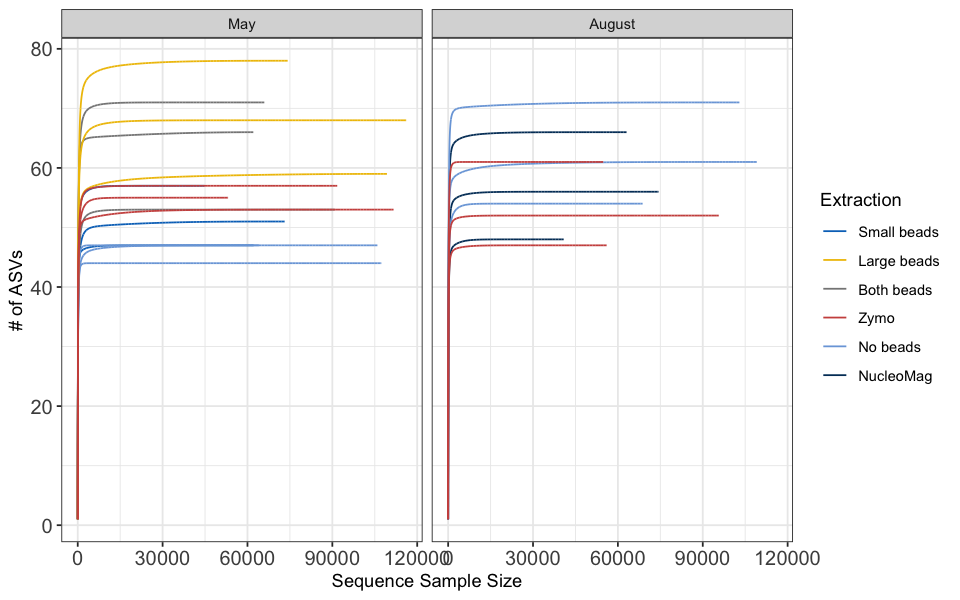

In [63]:
rare_12S <- ggrare(psnew_fish, step = 10, plot = FALSE, parallel = FALSE, se = FALSE, color = "Extraction")
rare_12S$data$Extraction <- factor(rare_12S$data$Extraction, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads", "NucleoMag"))
rare_12S + theme(legend.position = "none") + theme_bw()+ facet_grid(~factor(Day, levels = c("May", "August")), scales="free_y") +
labs(y="# of ASVs")+ theme(axis.text.x=element_text(size=12))+ theme(axis.text.y=element_text(size=12))+
scale_color_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF"))

#ggsave(filename="12S_rarefaction.pdf", plot= last_plot(), device = "pdf", path = NULL, scale = 1, width = 8, height = 4, dpi = 300)

Estimate mean, max and min sequence read counts across 12S samples. 

In [64]:
fish_min <- min(sample_sums(psnew_fish))
fish_mean <- mean(sample_sums(psnew_fish))
fish_max <- max(sample_sums(psnew_fish))

Rarefy the 12S data to an even sampling depth (min read count in dataset).

In [83]:
suppressMessages(ps_rarefy_12S <- rarefy_even_depth(psnew_fish, sample.size = min(sample_sums(psnew_fish)), rngseed = 714, replace = TRUE, trimOTUs = TRUE, verbose = TRUE))

Estimate observed ASV richness and Shannon diversity (for 12S) and combine in new data frame with specific metadata factors from the phyloseq object (extraction type and sampling day).

In [84]:
extraction_type = sample_data(ps_rarefy_12S)$Extraction
extraction_day = sample_data(ps_rarefy_12S)$Day
alpha_12S <- estimate_richness(ps_rarefy_12S, measures=c("Shannon", "Observed")) %>%
cbind(extraction_type, extraction_day)

Plot 12S species richness (# of ASVs) across bead treatments and for each sampling day.

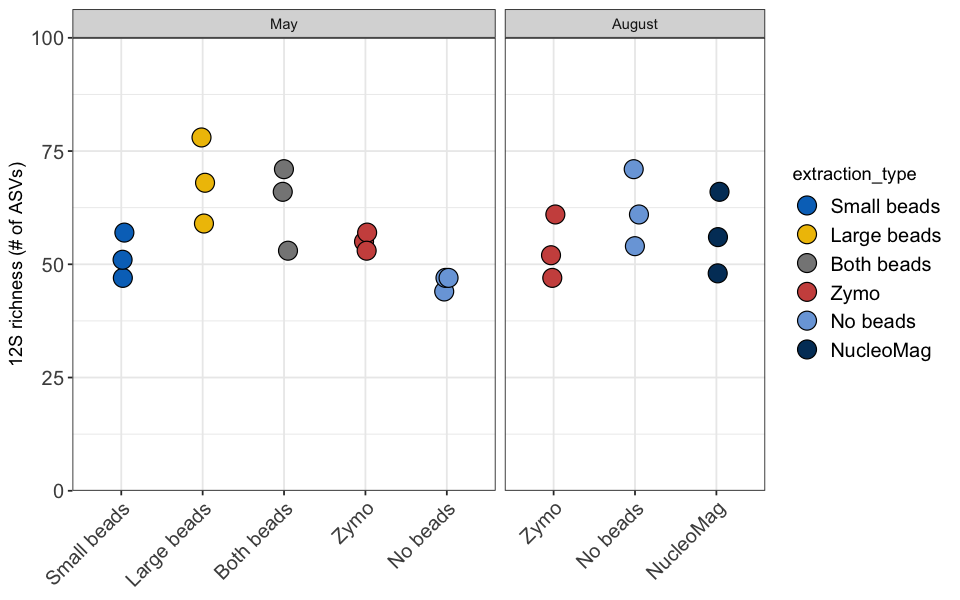

In [85]:
alpha_12S$extraction_type <- factor(alpha_12S$extraction_type, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads", "NucleoMag"))
Rich_12S <- ggplot(alpha_12S, aes(x=extraction_type, y = Observed, fill = extraction_type))
Rich_12S + geom_point(aes(fill = extraction_type),size = 5, shape = 21, colour = "black", position = position_jitterdodge(dodge.width=0.25)) +
   labs(y="12S richness (# of ASVs)") +
   scale_fill_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF")) +theme_bw() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size=12)) + 
   theme(axis.text.y = element_text(size=12))+ theme(legend.text = element_text(colour="black", size=12))+
   theme(axis.title.x = element_blank())+scale_y_continuous(expand = c(0, 0), breaks=seq(0,100,25), limits=c(0, 100))  + facet_grid(~factor(extraction_day, levels = c("May", "August")), scale = "free", space = "free")

#ggsave(filename="12S_Observed.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 4, dpi = 300)

Plot 12S Shannon diversity per extraction type and facet by day - May and August.

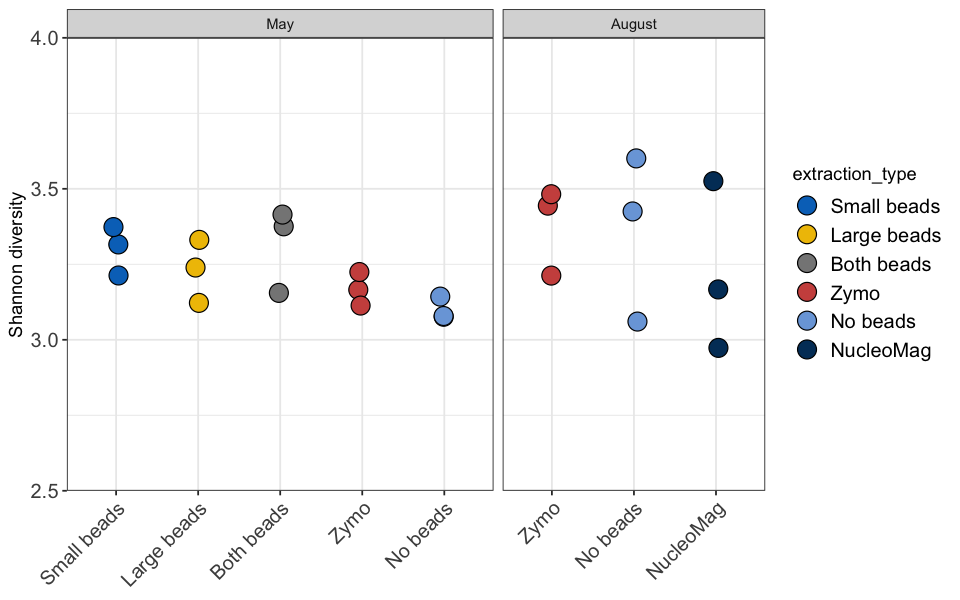

In [86]:
Shan_12S <- ggplot(alpha_12S, aes(x=extraction_type, y = Shannon, fill = extraction_type))
Shan_12S + geom_point(aes(fill = extraction_type),size = 5, shape = 21, colour = "black", position = position_jitterdodge(dodge.width=0.25)) +
   labs(y="Shannon diversity") +
   scale_fill_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF")) +theme_bw() + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size=12)) + 
   theme(axis.text.y = element_text(size=12))+ theme(legend.text = element_text(colour="black", size=12))+
   theme(axis.title.x = element_blank())+scale_y_continuous(expand = c(0, 0), breaks=seq(2.5,4,0.5), limits=c(2.5, 4))  + facet_grid(~factor(extraction_day, levels = c("May", "August")), scale = "free", space = "free")

#ggsave(filename="12S_Shannon.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 4, dpi = 300)

Test normality of the 12S data. 

In [87]:
shapiro.test(alpha_12S$Observed)
shapiro.test(alpha_12S$Shannon)


	Shapiro-Wilk normality test

data:  alpha_12S$Observed
W = 0.94282, p-value = 0.1885



	Shapiro-Wilk normality test

data:  alpha_12S$Shannon
W = 0.96384, p-value = 0.5202


ANOVA test with Tukey post-hoc for significant differences (p < 0.05) in richness and Shannon diversity between extraction types for May or August samples.

In [88]:
alpha_12S_may <- subset(alpha_12S, !grepl("August",alpha_12S$extraction_day))
may.aov <- aov(Observed~ extraction_type, data = alpha_12S_may)
TukeyHSD(may.aov)
may.aov <- aov(Shannon~ extraction_type, data = alpha_12S_may)
TukeyHSD(may.aov)

alpha_12S_aug <- subset(alpha_12S, !grepl("May",alpha_12S$extraction_day))
aug.aov <- aov(Observed~ extraction_type, data = alpha_12S_aug)
TukeyHSD(aug.aov)
aug.aov <- aov(Shannon~ extraction_type, data = alpha_12S_aug)
TukeyHSD(aug.aov)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Observed ~ extraction_type, data = alpha_12S_may)

$extraction_type
                              diff         lwr         upr     p adj
Large beads-Small beads  16.666667  -0.7065902 34.03992352 0.0615306
Both beads-Small beads   11.666667  -5.7065902 29.03992352 0.2509898
Zymo-Small beads          3.333333 -14.0399235 20.70659018 0.9663414
No beads-Small beads     -5.666667 -23.0399235 11.70659018 0.8158523
Both beads-Large beads   -5.000000 -22.3732568 12.37325685 0.8720306
Zymo-Large beads        -13.333333 -30.7065902  4.03992352 0.1602709
No beads-Large beads    -22.333333 -39.7065902 -4.96007648 0.0117684
Zymo-Both beads          -8.333333 -25.7065902  9.03992352 0.5406623
No beads-Both beads     -17.333333 -34.7065902  0.03992352 0.0505904
No beads-Zymo            -9.000000 -26.3732568  8.37325685 0.4724605


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Shannon ~ extraction_type, data = alpha_12S_may)

$extraction_type
                               diff        lwr        upr     p adj
Large beads-Small beads -0.06987685 -0.3150222 0.17526851 0.8757012
Both beads-Small beads   0.01455317 -0.2305922 0.25969853 0.9996136
Zymo-Small beads        -0.13290910 -0.3780545 0.11223626 0.4316941
No beads-Small beads    -0.20131960 -0.4464650 0.04382576 0.1232707
Both beads-Large beads   0.08443002 -0.1607153 0.32957538 0.7862532
Zymo-Large beads        -0.06303225 -0.3081776 0.18211311 0.9098147
No beads-Large beads    -0.13144275 -0.3765881 0.11370260 0.4416243
Zymo-Both beads         -0.14746227 -0.3926076 0.09768309 0.3403263
No beads-Both beads     -0.21587278 -0.4610181 0.02927258 0.0916868
No beads-Zymo           -0.06841051 -0.3135559 0.17673485 0.8834851


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Observed ~ extraction_type, data = alpha_12S_aug)

$extraction_type
                        diff       lwr      upr     p adj
No beads-Zymo       8.666667 -12.02576 29.35910 0.4526084
NucleoMag-Zymo      3.333333 -17.35910 24.02576 0.8766311
NucleoMag-No beads -5.333333 -26.02576 15.35910 0.7218737


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Shannon ~ extraction_type, data = alpha_12S_aug)

$extraction_type
                          diff        lwr       upr     p adj
No beads-Zymo      -0.01762286 -0.6239204 0.5886747 0.9956278
NucleoMag-Zymo     -0.15788612 -0.7641836 0.4484114 0.7172623
NucleoMag-No beads -0.14026326 -0.7465608 0.4660343 0.7669426


Remove the singletons or 12S sequences only observed once across the whole dataset. 

In [90]:
ps_rarefy_12S = filter_taxa(ps_rarefy_12S, function (x) {sum(x) > 1}, prune=TRUE)

Run ordination and plot PCoA based on weighted unifrac distances for 12S May and August bead samples.

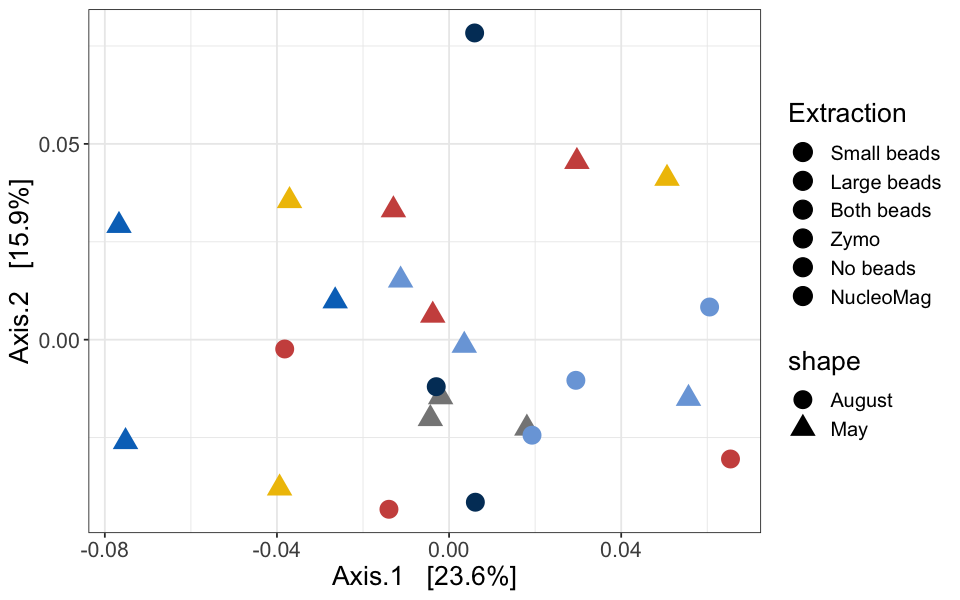

In [91]:
ps_12S_rel  <- transform_sample_counts(ps_rarefy_12S, function(x)100* x / sum(x))
ps_12S_ord  <- ordinate(ps_12S_rel, "PCoA", "unifrac", weighted = TRUE)
p_beta = plot_ordination(ps_12S_rel, ps_12S_ord, color="Extraction") + guides(color=FALSE)
p_beta$data$Extraction <- factor(p_beta$data$Extraction, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads", "NucleoMag"))
p_beta + theme_bw() + theme(text = element_text(size = 16)) + geom_point(aes(fill=Extraction, shape = Day),size = 5) + 
   scale_color_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF")) + 
   theme(legend.text = element_text(colour="black", size=12))

#ggsave(filename="12S_pcoa_days.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 7, height = 4, dpi = 300)

Run PERMANOVA to test significant differences (p < 0.05) in clustering based on bead treatment and sampling day for 12S.

In [92]:
perm_May <- subset_samples(ps_12S_rel, Day != "August")# Run May first - bead treatment.
metadata <- as(sample_data(perm_May), "data.frame")
adonis(phyloseq::distance(perm_May, method="bray") ~ Extraction,
       data = metadata)

perm_Aug <- subset_samples(ps_12S_rel, Day != "May")# Run August - bead treatment.
metadata <- as(sample_data(perm_Aug), "data.frame")
adonis(phyloseq::distance(perm_Aug, method="bray") ~ Extraction,
       data = metadata)

metadata <- as(sample_data(ps_12S_rel), "data.frame") # Both days included - sampling day.
adonis(phyloseq::distance(ps_12S_rel, method="bray") ~ Day,
       data = metadata)


Call:
adonis(formula = phyloseq::distance(perm_May, method = "bray") ~      Extraction, data = metadata) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
Extraction  4   0.48191 0.12048  1.0972 0.30501  0.171
Residuals  10   1.09806 0.10981         0.69499       
Total      14   1.57997                 1.00000       


Call:
adonis(formula = phyloseq::distance(perm_Aug, method = "bray") ~      Extraction, data = metadata) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
Extraction  2   0.26496 0.13248  1.1329 0.27413   0.16
Residuals   6   0.70160 0.11693         0.72587       
Total       8   0.96656                 1.00000       


Call:
adonis(formula = phyloseq::distance(ps_12S_rel, method = "bray") ~      Day, data = metadata) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)  
Day        1   0.15448 0.15448  1.3346 0.05719   0.05 *
Residuals 22   2.54652 0.11575         0.94281         
Total     23   2.70100                 1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Find out the most relatively abundant 12S groups across May and August samples - at the family level.

In [74]:
ps_rarefy_12S <- name_taxa(ps_rarefy_12S, label = "Unassigned")
family_12S <- tax_glom(ps_rarefy_12S, taxrank = "Family")
family_12S <- transform_sample_counts(family_12S, function(x)100* x / sum(x))
OTU <- otu_table(family_12S)
TAX <- tax_table(family_12S)[,"Family"]
Average <- as.data.frame(rowMeans(OTU))
names(Average) <- c("Mean")
Table <- merge(TAX, Average, by=0, all=TRUE)
Table$Row.names = NULL
Table <- Table[order(desc(Table$Mean)),]
head(Table)

,Family,Mean
,<fct>,<dbl>
10,Salmonidae,23.848967
1,Lutjanidae,15.167805
9,Clupeidae,14.236677
16,Mugilidae,10.810227
46,Ammodytidae,7.054316
23,Scombridae,5.946995


Plot taxa bar plots at the family level (>5% relative abundance) for 12S across bead treatments and days.

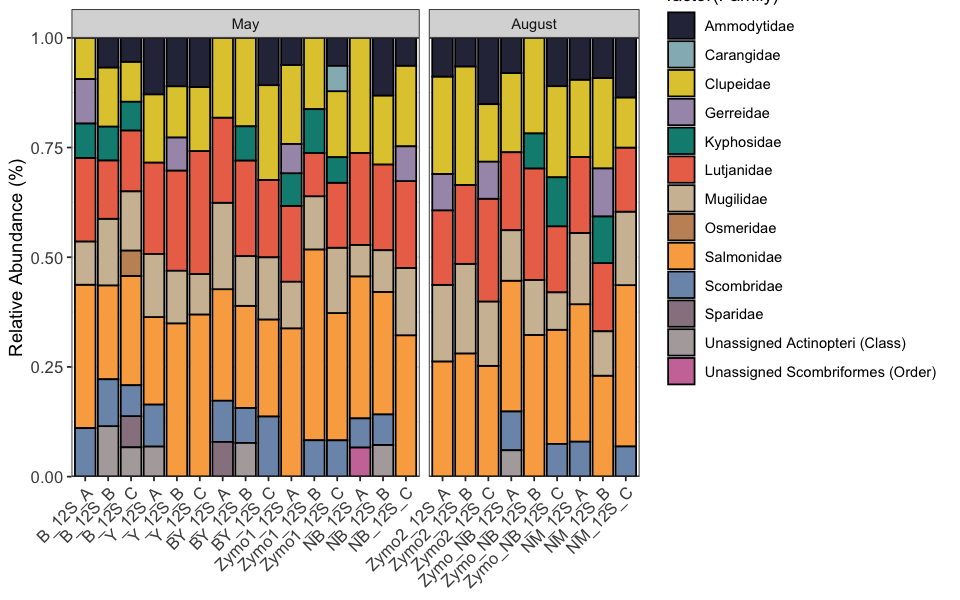

In [75]:
barplot_12S <- ps_rarefy_12S %>%
   tax_glom(taxrank = "Family", NArm=FALSE) %>%                 # Agglomerate at class level
   transform_sample_counts(function(OTU) 100* OTU/sum(OTU)) %>% # Transform to relative abundance
   psmelt()   %>%                                               # Melt to long format
   filter(Abundance > 5)                                        # Filter out families <5% in any sample
barplot_12S$Family<- as.character(barplot_12S$Family)
barplot_12S$Day <- factor(barplot_12S$Day, levels = c("May", "August"))
p_taxa_12S <- ggplot(data=barplot_12S, aes(x=Sample, y=Abundance, fill=factor(Family)))

# Set order of samples on x-axis.                           
p_taxa_12S$data$Sample <- factor(p_taxa_12S$data$Sample, levels = c("B_12S_A","B_12S_B","B_12S_C","Y_12S_A", "Y_12S_B", "Y_12S_C", "BY_12S_A", "BY_12S_B", "BY_12S_C", "Zymo1_12S_A","Zymo1_12S_B", "Zymo1_12S_C","NB_12S_A", "NB_12S_B", "NB_12S_C", "Zymo2_12S_A", "Zymo2_12S_B", "Zymo2_12S_C", "Zymo_NB_12S_A", "Zymo_NB_12S_B", "Zymo_NB_12S_C", "NM_12S_A", "NM_12S_B", "NM_12S_C"))
p_taxa_12S + geom_bar(aes(), stat="identity", position="fill", colour="black", width = 0.9)+
   scale_y_continuous(expand = c(0, 0))+
   geom_hline(yintercept=0) + theme_bw()+ scale_fill_manual(values= c("#2E3047","#94B8BE","#E0C93B", "#A799B7", "#0A8B81", "#EB7357", "#D0BDA2", "#C49264", "#FAAB50", "#7D97B8", "#98838F", "#B2AAAB", "#CC79A7"))  + 
   theme(axis.text.x=element_text(angle=45,vjust =1, hjust=1, size=10)) + theme(axis.text.y=element_text(size=10))+
   theme(legend.position="right") +guides(fill=guide_legend(nrow=18, ncol=1)) +
   theme(axis.title.x=element_blank())+ 
   labs(y = "Relative Abundance (%)") + facet_grid(~factor(Day, levels = c("May", "August")), scale = "free", space = "free")

#ggsave(filename="12S_bar_family.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 6, dpi = 300)

Dot plot of the top 20 most relatively abundant 12S ASVs in May.

Warning message:
“Removed 52 rows containing missing values (geom_point).”


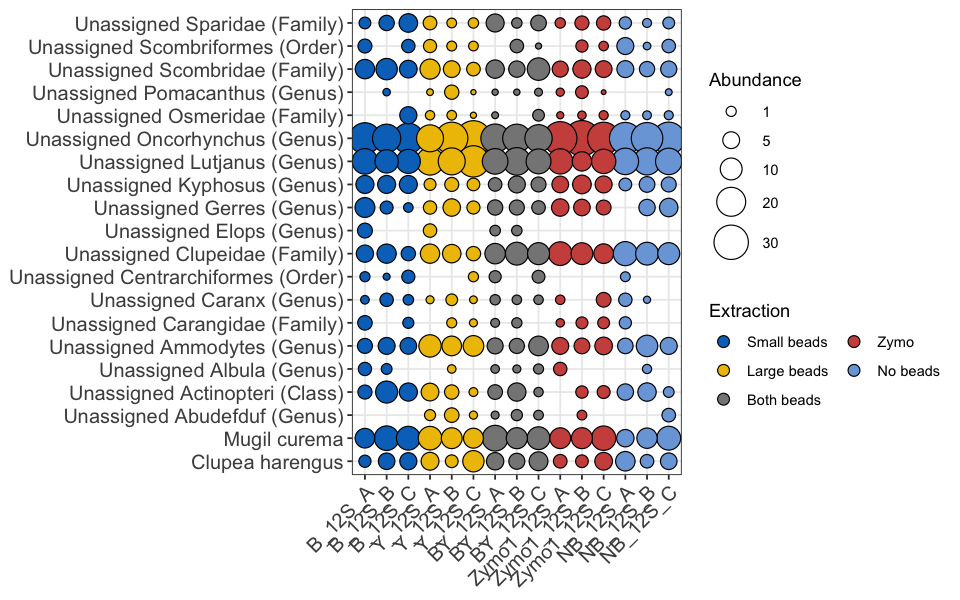

In [76]:
ps_12S_May = subset_samples(ps_rarefy_12S, Day != "August") 
ps_12S_top <- tax_glom(ps_12S_May, taxrank = "Species", NArm=FALSE)
ps2 <-  transform_sample_counts(ps_12S_top , function(OTU) 100* OTU/sum(OTU))
P20 = prune_taxa(names(sort(taxa_sums(ps2), TRUE))[1:20], ps2)
ps_melt <- psmelt(P20)
 
p <- ggplot(ps_melt, aes(x=Sample, y = Species))
p$data$Extraction <- factor(p$data$Extraction, levels = c("Small beads", "Large beads", "Both beads", "Zymo", "No beads"))
p$data$Sample <- factor(p$data$Sample, levels = c("B_12S_A","B_12S_B","B_12S_C","Y_12S_A", "Y_12S_B", "Y_12S_C", "BY_12S_A", "BY_12S_B", "BY_12S_C", "Zymo1_12S_A","Zymo1_12S_B", "Zymo1_12S_C","NB_12S_A", "NB_12S_B", "NB_12S_C", "Zymo2_12S_A", "Zymo2_12S_B", "Zymo2_12S_C", "Zymo_NB_12S_A", "Zymo_NB_12S_B", "Zymo_NB_12S_C", "NM_12S_A", "NM_12S_B", "NM_12S_C"))
p + geom_point(aes(size=Abundance, fill= Extraction), alpha = 1, shape = 21) + theme_bw() +
   scale_fill_manual(values=c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF")) + 
   theme(axis.text.x=element_text(angle=45,vjust =1, hjust=1, size=12)) + theme(axis.text.y=element_text(size =12))+
   scale_size_continuous(limits = c(0.007346099, 35), range=c(1,10), breaks = c(1, 5, 10, 20, 30)) +
   theme(axis.title.x = element_blank(),axis.title.y = element_blank())+
   guides(fill=guide_legend(ncol=2, override.aes = list(size=3)))

#ggsave(filename="top20_ASVs_12S_May.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 9, height = 6, dpi = 300)

Dot plot of the top 20 most relatively abundant 12S ASVs in August.

Warning message:
“Removed 37 rows containing missing values (geom_point).”


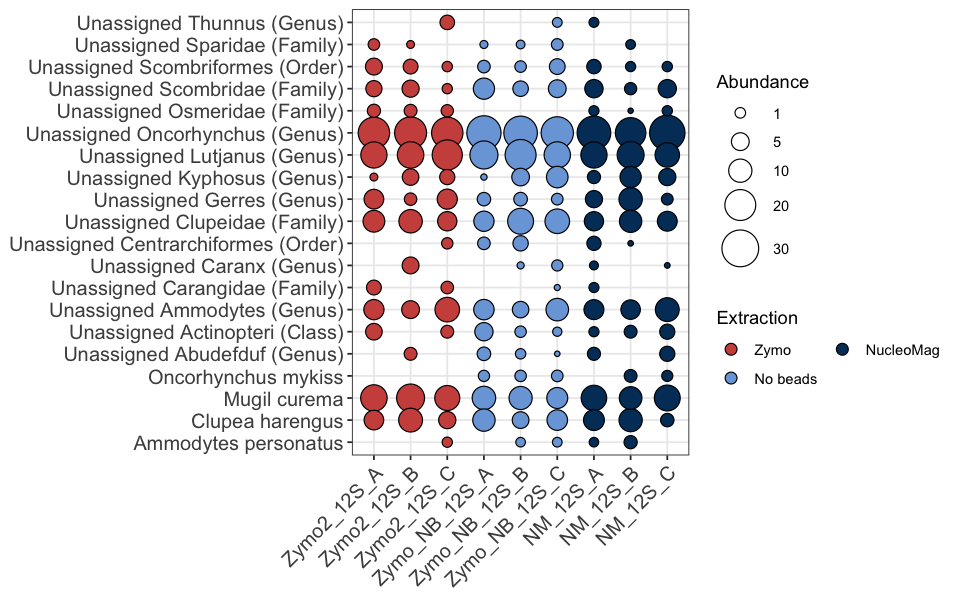

In [196]:
ps_12S_Aug = subset_samples(ps_rarefy_12S, Day != "May") 
ps_12S_Aug <- name_taxa(ps_12S_Aug, label = "Unassigned")
ps_12S_top <- tax_glom(ps_12S_Aug, taxrank = "Species", NArm=FALSE)
ps2 <-  transform_sample_counts(ps_12S_top , function(OTU) 100* OTU/sum(OTU))
P20 = prune_taxa(names(sort(taxa_sums(ps2), TRUE))[1:20], ps2)
ps_melt <- psmelt(P20)

p <- ggplot(ps_melt, aes(x=Sample, y = Species))
p$data$Extraction <- factor(p$data$Extraction, levels = c( "Zymo", "No beads", "NucleoMag"))
p$data$Sample <- factor(p$data$Sample, levels = c("Zymo2_12S_A", "Zymo2_12S_B", "Zymo2_12S_C", "Zymo_NB_12S_A", "Zymo_NB_12S_B", "Zymo_NB_12S_C", "NM_12S_A", "NM_12S_B", "NM_12S_C"))
p + geom_point(aes(size=Abundance, fill= Extraction), alpha = 1, shape = 21) + theme_bw() +
   scale_fill_manual(values=c("#CD534CFF", "#7AA6DCFF", "#003C67FF")) + 
   theme(axis.text.x=element_text(angle=45,vjust =1, hjust=1, size=12)) +theme(axis.text.y=element_text(size =12))+
   scale_size_continuous(limits = c(0.00244870, 30), range=c(1,10), breaks = c(1, 5, 10, 20, 30)) +
   theme(axis.title.x = element_blank(),axis.title.y = element_blank())+
   guides(fill=guide_legend(ncol=2, override.aes = list(size=3)))

#ggsave(filename="top20_ASVs_12S_Aug.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 9, height = 6, dpi = 300)

Use ps_venn function to estimate percentage of 12S ASVs shared between bead treatments in May and August.

In [93]:
invisible(capture.output(ps_venn(perm_May, group="Extraction", fraction =1, weight = FALSE, type = "percent", relative = FALSE, plot = FALSE)))   
perm_May2 = subset_samples(perm_May, Extraction == "Zymo" | Extraction == "No beads")
invisible(capture.output(ps_venn(perm_May2, group="Extraction", fraction =1, weight = FALSE, type = "percent", relative = FALSE, plot = FALSE)))


invisible(capture.output(ps_venn(perm_Aug, group="Extraction", fraction =1, weight = FALSE, type = "percent", relative = FALSE, plot = FALSE)))
perm_Aug2 = subset_samples(perm_Aug, Extraction == "Zymo" | Extraction == "No beads")
invisible(capture.output(ps_venn(perm_Aug2, group="Extraction", fraction =1, weight = FALSE, type = "percent", relative = FALSE, plot = FALSE)))

Plot box plots of the top 20 most relatively abundant 12S ASVs over both sampling days. These represent the top fish taxa that were included in our expert poll.

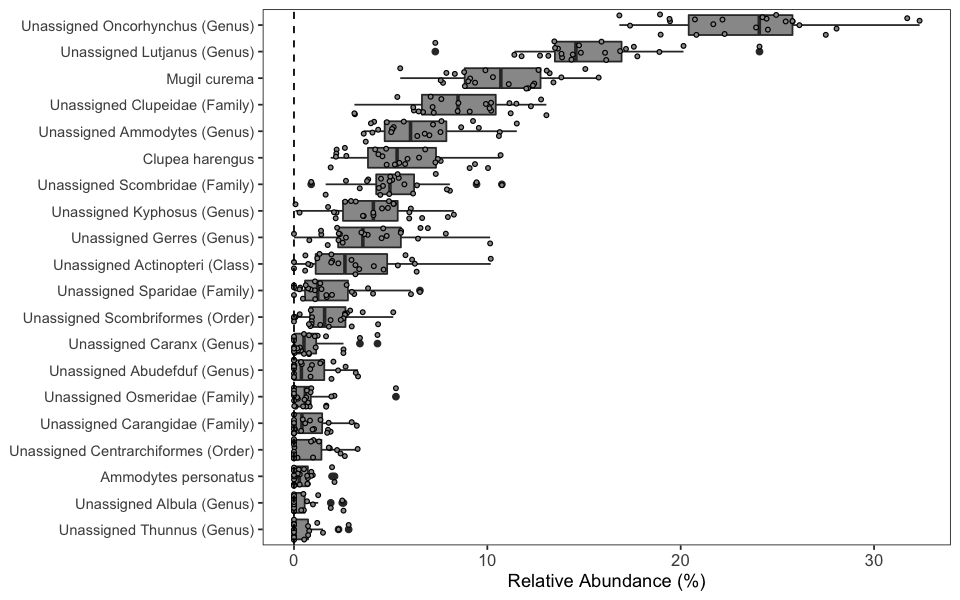

In [78]:
ps_12S_top <- tax_glom(ps_rarefy_12S, taxrank = "Species", NArm=FALSE)
ps2 <-  transform_sample_counts(ps_12S_top , function(x) x / sum(x) )
P20 = prune_taxa(names(sort(taxa_sums(ps2), TRUE))[1:20], ps2)
ps_melt <- psmelt(P20)
ps_melt$Abundance <- ps_melt$Abundance * 100

p <- ggplot(ps_melt, aes(x=Abundance, y = reorder(Species, Abundance)))
p$data$Sample <- factor(p$data$Sample, levels = c("B_12S_A", "B_12S_B", "B_12S_C", "Y_12S_A", "Y_12S_B", "Y_12S_C", "BY_12S_A", "BY_12S_B", "BY_12S_C", "Zymo1_12S_A", "Zymo1_12S_B", "Zymo1_12S_C", "NB_12S_A", "NB_12S_B", "NB_12S_C"))
p + geom_boxplot(fill = "gray60", alpha = 1)+
   geom_point(size =1, shape = 21, fill = "gray60", position="jitter")+ theme_bw() +
   theme(axis.text.x=element_text(size=10)) +  geom_vline(xintercept=c(0,0), linetype="dashed")+                                 
   theme(axis.title.y = element_blank())+labs(x = "Relative Abundance (%)")+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
   guides(fill=guide_legend(ncol=1))

#ggsave(filename="top20_OTUs_12S_survey.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 6, height = 5, dpi = 300)

Bar plots to show composition of the 12S bacteria community. 

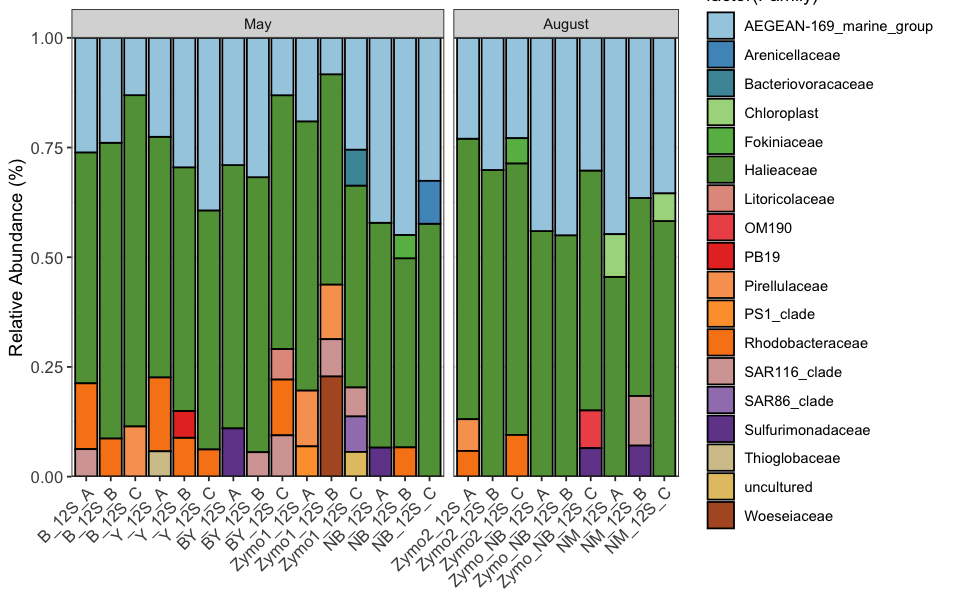

In [201]:
suppressMessages(ps_rarefy_bact <- rarefy_even_depth(psnew_bact, sample.size = min(sample_sums(psnew_bact)), rngseed = 714, replace = TRUE, trimOTUs = TRUE, verbose = TRUE))
ps_rarefy_bact = filter_taxa(ps_rarefy_bact, function (x) {sum(x) > 1}, prune=TRUE)
ps_rarefy_bact <- name_taxa(ps_rarefy_bact, label = "Unassigned")
barplot_bact <- ps_rarefy_bact %>%
   tax_glom(taxrank = "Family", NArm=FALSE) %>%                 # Agglomerate at class level
   transform_sample_counts(function(OTU) 100* OTU/sum(OTU)) %>% # Transform to relative abundance
   psmelt()   %>%                                               # Melt to long format
   filter(Abundance > 5)
barplot_bact$Family<- as.character(barplot_bact$Family)
barplot_bact$Day <- factor(barplot_bact$Day, levels = c("May", "August"))
p_taxa_bact <- ggplot(data=barplot_bact, aes(x=Sample, y=Abundance, fill=factor(Family)))
p_taxa_bact$data$Sample <- factor(p_taxa_bact$data$Sample, levels = c("B_12S_A","B_12S_B","B_12S_C","Y_12S_A", "Y_12S_B", "Y_12S_C", "BY_12S_A", "BY_12S_B", "BY_12S_C", "Zymo1_12S_A","Zymo1_12S_B", "Zymo1_12S_C","NB_12S_A", "NB_12S_B", "NB_12S_C", "Zymo2_12S_A", "Zymo2_12S_B", "Zymo2_12S_C", "Zymo_NB_12S_A", "Zymo_NB_12S_B", "Zymo_NB_12S_C", "NM_12S_A", "NM_12S_B", "NM_12S_C"))
nb.cols <- 18
mycolors <- colorRampPalette(brewer.pal(12, "Paired"))(nb.cols)
p_taxa_bact + geom_bar(aes(), stat="identity", position="fill", colour="black", width = 0.9)+
   scale_y_continuous(expand = c(0, 0))+
   geom_hline(yintercept=0) + theme_bw()+ scale_fill_manual(values=mycolors)+ 
   theme(axis.text.x=element_text(angle=45,vjust =1, hjust=1, size=10)) + theme(axis.text.y=element_text(size=10))+ 
   theme(legend.position="right") +
   guides(fill=guide_legend(nrow=18, ncol=1)) + theme(axis.title.x=element_blank())+ 
   labs(y = "Relative Abundance (%)") + facet_grid(~factor(Day, levels = c("May", "August")), scale = "free", space = "free")
                           
#ggsave(filename="12S_bact_family.eps", plot= last_plot(), device = "eps", path = NULL, scale = 1, width = 8, height = 6, dpi = 300)

Plot the percent overlap of ASVs across the different marker gene regions. These values were estimated earlier using the ps_venn function. We will import these values in a .csv file. 

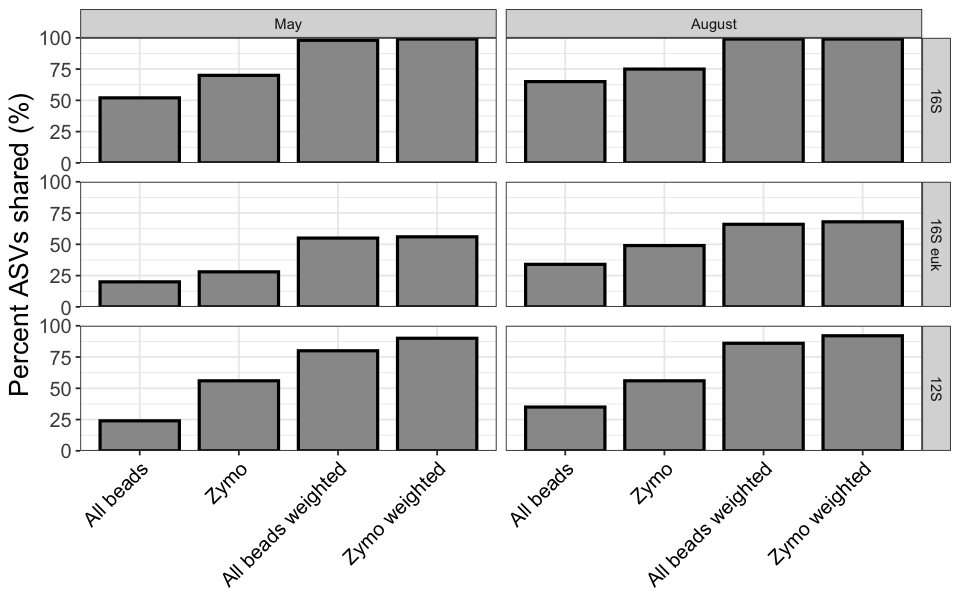

In [202]:
overlap <- read.csv("/Asv_overlap.csv", header=T, row.names = NULL, check.names=F,fileEncoding="UTF-8-BOM")
p <- ggplot(overlap, aes(x=Treatment, y=Percent)) 
p$data$Gene <- factor(p$data$Gene, levels = c("16S", "16S euk", "12S"))
p$data$Month <- factor(p$data$Month, levels = c("May", "August"))
p$data$Treatment <- factor(p$data$Treatment, levels = c("All beads", "Zymo", "All beads weighted", "Zymo weighted"))
p + geom_col(fill = "gray60", width = 0.8, colour = "black", size = 0.9)  + theme_bw()+
   scale_y_continuous(name="Percent ASVs shared (%)", limits=c(0, 100), expand = c(0, 0)) + theme(axis.title.x=element_blank()) + facet_grid(Gene ~ Month)+ theme(panel.spacing.y = unit(4, "mm"))+
   theme(axis.text.x=element_text(angle=45,vjust=1, hjust=1, size=12, color="black"))+ theme(axis.text.y=element_text(size=12)) + theme(axis.title.y = element_text(size = 16))

#ggsave(filename = "shared_ASVs.eps", plot = last_plot(), device = "eps", path = NULL, scale = 1, width = 4, height = 5, units = c("in", "cm", "mm"), dpi = 300) 